# Concrete Cracks Detection Using Transfer Learning


# Import Required Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        classification_report, 
        confusion_matrix,
        precision_recall_curve,
        average_precision_score,
        ConfusionMatrixDisplay,
        PrecisionRecallDisplay,
      )
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from pathlib import Path
import random
import sys, os
import shutil
from glob import glob
import imageio
import matplotlib
# matplotlib.style.use('ggplot')

# Hardcode Configuration

**IMPORTANT**: Update Information To Function Properly.

## Fill Up The Form First

In [ ]:
#@title ## Configuration Form

#@markdown ---
#@markdown #### **Developer Attention**
#@markdown **Development Stage**:
#@markdown Set it `False` during production or final stage.
#@markdown When it set to `True`, this will train on less data 
#@markdown to reduce training time in development stage.
_is_development_stage = False #@param {type:"boolean"}

#@markdown **Active Initial Training Stage**:
#@markdown When it is `True`, then `Initial Training` will be happen.
#@markdown It sould be active at the first time training, later only  
#@markdown `Resume Training` should be active for repeatative training epochs.
_is_active_initial_training_stage = False #@param {type:"boolean"}
#@markdown ---
#@markdown **Resume Training**:
#@markdown When it is `True`, then `Resume Training` will be happen.
_is_resume_training_stage = True #@param {type:"boolean"}
#@markdown ---
#@markdown **Evaluation Active**:
#@markdown When it is `True`, then `Evaluation` will be happen.
_is_active_evaluation_stage = True #@param {type:"boolean"}
#@markdown ---
#@markdown **Google Drive Related**:
#@markdown Using google drive is suitable than local machine
#@markdown because it takes less time to move arround files.
_save_models_to_google_drive = True #@param {type:"boolean"}
_load_models_from_google_drive = True #@param {type:"boolean"}
_save_logs_to_google_drive = True #@param {type:"boolean"}
_use_dataset_from_google_drive = False #@param {type:"boolean"}
_use_dataset_file_names_from_google_drive = True #@param {type:"boolean"}
_save_colab_dataset_to_google_drive = False #@param {type:"boolean"}
#@markdown **Google Drive Path**:
#@markdown Give a valid `Path` by selecting or editing.
#@markdown Make sure path exist on google drive.
_google_drive_models_path = 'MyDrive/ML/concrete-crack-detection/models' #@param ["MyDrive/ML/concrete-crack-detection/models", "MyDrive/academic/research/concrete-crack-detection/models"] {allow-input: true}
_google_drive_logs_path = 'MyDrive/ML/concrete-crack-detection/logs' #@param ["MyDrive/ML/concrete-crack-detection/logs", "MyDrive/academic/research/concrete-crack-detection/logs"] {allow-input: true}
_google_drive_dataset_path = 'MyDrive/ML/concrete-crack-detection/data' #@param ["MyDrive/ML/concrete-crack-detection/data", "MyDrive/academic/research/concrete-crack-detection/data"] {allow-input: true}
_google_drive_dataset_file_names_path = 'MyDrive/ML/concrete-crack-detection/data/file-names' #@param ["MyDrive/ML/concrete-crack-detection/data/file-names", "MyDrive/academic/research/concrete-crack-detection/data/file-names"] {allow-input: true}
#@markdown ---

#@markdown **Local Computer Related**:
#@markdown Using local computer is not easy as google drive,
#@markdown because it takes more time to move arround files.
_download_saved_models_to_local_machine = False #@param {type:"boolean"}
_upload_saved_models_from_local_machine = False #@param {type:"boolean"}
#@markdown ---

#@markdown #### **Number of Training Epochs**
#@markdown Initial trainig epochs only be used first time model train.
#@markdown Then the initial trained models checkpoint will be saved for
#@markdown later training starting from last epochs (Resume Training).
_initial_trainig_epochs =  1 #@param {type:"slider", min:1, max:100, step:1}

#@markdown Resume trainig epochs will be used to train resume trainig from
#@markdown the previous trained models checkpoint, and after finishing this
#@markdown training it will save current models checkpoint 
#@markdown again for later Resume Training.
_resume_trainig_epochs = 1 #@param {type:"slider", min:1, max:100, step:1}
#@markdown ---
#@markdown #### **Batch Size**
#@markdown It will be used during load data and training.
#@markdown If there found memory limitation try to reduce it.
_batch_size = 128 #@param [128, 64, 32, 16]
#@markdown ---
#@markdown #### **Clear Google Colab** content directory
#@markdown If it is `True` some files will be removed from colab
#@markdown which are generated previous times. Example: logs, data, models etc
_clean_colab_unwanted_files = True #@param {type:"boolean"}
#@markdown ---

## Validate Form and Set Up Configurations

In [ ]:
# This is for reducing train and test time during code testing or development stage
# Make it False in finela stage
DEVELOPMENT_STAGE = _is_development_stage

# It sould be active at the first time training, later only  
# `Resume Training` should be active for repeatative training epochs.
ACTIVE_INITIAL_TRAINING_STAGE = _is_active_initial_training_stage

# If its True then Resume Training will be happen.
RESUME_TRAINING_STAGE = _is_resume_training_stage

# If this is True, it will evaluate models and create history logs
ACTIVE_EVALUATION_STAGE = _is_active_evaluation_stage

# Google Drive path for saved models
SAVE_MODELS_TO_GOOGLE_DRIVE = _save_models_to_google_drive
GOOGLE_DRIVE_MODELS_PATH = _google_drive_models_path
LOAD_MODELS_FROM_GOOGLE_DRIVE = _load_models_from_google_drive
SAVE_LOGS_TO_GOOGLE_DRIVE = _save_logs_to_google_drive
GOOGLE_DRIVE_LOGS_PATH = _google_drive_logs_path
LOAD_DATASET_FROM_GOOGLE_DRIVE = _use_dataset_from_google_drive
GOOGLE_DRIVE_DATASET_PATH = _google_drive_dataset_path
SAVE_COLAB_DATASET_TO_GOOGLE_DRIVE = _save_colab_dataset_to_google_drive
USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE = _use_dataset_file_names_from_google_drive
GOOGLE_DRIVE_DATASET_FILE_NAMES_PATH = _google_drive_dataset_file_names_path

# Download Saved Models to Local Machine
DOWNLOAD_SAVED_MODELS_LOCALY = _download_saved_models_to_local_machine

# Load Saved Models from Local Machine
LOAD_MODELS_FROM_LOCAL = _upload_saved_models_from_local_machine

# Trainig and Validation EPOCHS
INITIAL_TRAINING_EPOCHS = _initial_trainig_epochs
RESUME_TRAINING_EPOCHS = _resume_trainig_epochs

# Batch Size
BATCH_SIZE = _batch_size

# Dataset Directory Name
DATASET_DIRNAME = 'data'

# This is the root directory of dataset
# this path can be changed 
# i.e when using mounted google drive dataset this path will be updated
DATASET_PATH = Path('data')

# Logs Directory Name
LOGS_DIRNAME = 'logs'

# Models Directory Name in Colab
MODELS_DIRNAME_COLAB = 'models'

# Clear Colab by removing previous files/folder
CLEAN_COLAB = _clean_colab_unwanted_files

## Clear Google Colab Directory (IF Needed)

In [ ]:
# clear logs
if os.path.exists(Path(LOGS_DIRNAME)):
  try:
    os.system(f"rm -r {Path(LOGS_DIRNAME)}/")
  except Exception as e:
    print(e)
  try:
    os.makedirs(Path(LOGS_DIRNAME), exist_ok=True)
  except OSError as e:
    pass
else:
  try:
    os.makedirs(Path(LOGS_DIRNAME), exist_ok=True)
  except OSError as e:
    pass

# clear dataset dir
if os.path.exists(Path(DATASET_DIRNAME)):
  try:
    os.system(f"rm -r {Path(DATASET_DIRNAME)}/")
  except Exception as e:
    print(e)
  try:
    os.makedirs(Path(DATASET_DIRNAME), exist_ok=True)
  except OSError as e:
    pass

# clear `Positive` and `Negative`  dir of downloaded dataset
if os.path.exists(Path('Positive')) or os.path.exists(Path('Negative')):
  try:
    os.system(f"rm -r Positive Negative")
  except Exception as e:
    print(e)

# clear colab models dir
if os.path.exists(Path(MODELS_DIRNAME_COLAB)):
  try:
    os.system(f"rm -r {Path(MODELS_DIRNAME_COLAB)}/")
  except Exception as e:
    print(e)
  try:
    os.makedirs(Path(MODELS_DIRNAME_COLAB), exist_ok=True)
  except OSError as e:
    pass
else:
  try:
    os.makedirs(Path(MODELS_DIRNAME_COLAB), exist_ok=True)
  except OSError as e:
    pass


## Give Google Drive Access (If Required) and Validate Config

In [ ]:
# Google Drive Mount Directory Name
GOOGLE_DRIVE_MOUNTED_DIRNAME = 'gdrive'

In [ ]:
# If there need to access Google Drive Mount at Google Drive
if SAVE_MODELS_TO_GOOGLE_DRIVE or \
  LOAD_MODELS_FROM_GOOGLE_DRIVE or \
  SAVE_LOGS_TO_GOOGLE_DRIVE or \
  LOAD_DATASET_FROM_GOOGLE_DRIVE or\
  USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNTED_DIRNAME)

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
# Now Validate Some User Given Drive Path
if SAVE_MODELS_TO_GOOGLE_DRIVE or LOAD_MODELS_FROM_GOOGLE_DRIVE:
  _gdrive_path = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_MODELS_PATH
  if not os.path.exists(_gdrive_path):
    raise Exception(f"Google Drive Path '{_gdrive_path}' does not exist")
if SAVE_LOGS_TO_GOOGLE_DRIVE:
  _gdrive_path = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_LOGS_PATH
  if not os.path.exists(_gdrive_path):
    raise Exception(f"Google Drive Path '{_gdrive_path}' does not exist")
if LOAD_DATASET_FROM_GOOGLE_DRIVE:
  _gdrive_path = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_DATASET_PATH
  if not os.path.exists(_gdrive_path):
    raise Exception(f"Google Drive Path '{_gdrive_path}' does not exist")
  
  # Update DATASET_PATH path so that data use from mounted gdrive
  DATASET_PATH = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ f"{GOOGLE_DRIVE_DATASET_PATH}"

# if USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE is True then 
if USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
  _gdrive_path = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ GOOGLE_DRIVE_DATASET_FILE_NAMES_PATH
  if not os.path.exists(_gdrive_path):
    raise Exception(f"Google Drive Path '{_gdrive_path}' does not exist")
  
  # use only one dataset
  # so set false to LOAD_DATASET_FROM_GOOGLE_DRIVE
  if LOAD_DATASET_FROM_GOOGLE_DRIVE:
    LOAD_DATASET_FROM_GOOGLE_DRIVE = False
    DATASET_PATH = DATASET_DIRNAME

## Device (CPU, GPU, TPU)

In [ ]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fandamental Preparation

**NOTE**: This block of cells required for all subsequent Block of Cells.

## Useful Functions

In [ ]:
# It will print tree of a directory with optional files path
def tree_printer(root, show_files=False):
  for root, dirs, files in os.walk(root):
    for d in dirs:
      print(os.path.join(root, d))
    if show_files:
      for f in files:
        print(os.path.join(root, f))

In [ ]:
# A utility function for copying files and directory
def copytree(src, dst, symlinks = False, ignore = None):
  """
  - Same behavior as shutil.copytree, with symlinks and ignore parameters
  - Create directory destination structure if non existant
  - Will not fail if dst already exists
  Details: https://stackoverflow.com/a/22331852/8520849
  """
  if not os.path.exists(dst):
    os.makedirs(dst)
    shutil.copystat(src, dst)
  lst = os.listdir(src)
  if ignore:
    excl = ignore(src, lst)
    lst = [x for x in lst if x not in excl]
  for item in lst:
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    if symlinks and os.path.islink(s):
      if os.path.lexists(d):
        os.remove(d)
      os.symlink(os.readlink(s), d)
      try:
        st = os.lstat(s)
        mode = stat.S_IMODE(st.st_mode)
        os.lchmod(d, mode)
      except:
        pass # lchmod not available
    elif os.path.isdir(s):
      copytree(s, d, symlinks, ignore)
    else:
      shutil.copy2(s, d)

## Prepare Dataset


We will use **[Concrete Crack Images for Classification](https://data.mendeley.com/datasets/5y9wdsg2zt/2)** dataset for proposed models.

**Description**: The dataset contains concrete images having cracks. The data is collected from various METU Campus Buildings.
The dataset is divided into two as negative and positive crack images for image classification. 
Each class has 20000 images with a total of 40000 images with 227 x 227 pixels with RGB channels. 
The dataset is generated from 458 high-resolution images (4032x3024 pixel) with the method proposed by Zhang et al (2016). 
High-resolution images have variance in terms of surface finish and illumination conditions. 
No data augmentation in terms of random rotation or flipping is applied.

**Dataset Link**: https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip


*Cite this dataset*: Zhang, Lei, et al. "Road crack detection using deep convolutional neural network." 2016 IEEE international conference on image processing (ICIP). IEEE, 2016.

### Download, Unzip, Unrar and Organize Dataset (IF NEEDED)


#### Download Dataset


In [ ]:
if (not LOAD_DATASET_FROM_GOOGLE_DRIVE) or USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
  # download data
  # !wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
  dataset_url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip"
  downloaded_dataset_file_name = '5y9wdsg2zt-2.zip'
  try:
    if os.path.exists(downloaded_dataset_file_name):
      pass
    else:
      os.system(f"wget {dataset_url}")
  except Exception as e:
    raise e
  # list out current directory
  print(*os.listdir('.'), sep='\n')

.config
data
models_gdrive
gdrive
5y9wdsg2zt-2.zip
models
logs
Concrete Crack Images for Classification.rar


#### Unzip Dataset

**Unzip Files**: Use this command to perform various operations on a ZIP archive file’s contents.

The “<ZIPFILE>” variable is the complete path and filename of the Zip file to be targeted, while the “ <FILE-or-DIRECTORY>” variable should be the file or directory that will be the target of the operation. This is all based on the selected “ <OPTIONS>” and “ <MODIFIERS>” set.
```
unzip <OPTIONS> [MODIFIER] <ZIPFILE> [<OPTIONS>] <FILE_or_DIRECTORY>
```
*Note*: Only a single hyphen (-) is required when calling out more than one option (e.g., -fldv would be set to include the -f, -l, -d and -v options in a single command.

Some available options:
* `-l`:	Display the ZIP archive file’s contents using a shortened format.
* `-d`:	Uncompress files to directory.
* `-x`:	Do not extract the file or files that follow.
Some available modifiers:
* `-q`:	Perform the operation quietly; do not display the operation’s step-by-step execution
* `-qq`:	Perform the operation even more quietly than with `-q`
* `-o`:	Do not prompt before overwriting files



In [ ]:
if (not LOAD_DATASET_FROM_GOOGLE_DRIVE) or USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
  # list out current directory
  print(*os.listdir('.'), sep='\n')
  ziped_dataset_path = "5y9wdsg2zt-2.zip"
  # unzip files
  try:
    os.system(f"unzip -qq -o {ziped_dataset_path}")
  except Exception as e:
    raise e
  # list out current directory
  print(*os.listdir('.'), sep='\n')

.config
data
models_gdrive
gdrive
5y9wdsg2zt-2.zip
models
logs
Concrete Crack Images for Classification.rar
.config
data
models_gdrive
gdrive
5y9wdsg2zt-2.zip
models
logs
Concrete Crack Images for Classification.rar


#### Unrar Dataset


**Unrar Files**:
To open or extract a .rar extension file in any specific path or directory, type the following command in the terminal. This will extract the files and locate them in the specified directory.
```
$ unrar  e filename.rar /home/
```

If you want to open or extract a .rar extension file in their original directory, use the following command:
```
$ unrar x filename.rar
```



In [ ]:
if (not LOAD_DATASET_FROM_GOOGLE_DRIVE) or USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
  # unrar file
  rar_dataset_path = 'Concrete Crack Images for Classification.rar'
  # try:
  #   os.system(f"unrar x {rar_dataset_path}")
  # except OSError as e:
  #   raise e
  !unrar x 'Concrete Crack Images for Classification.rar'

  # list out current directory
  # we will see two directory: 'Positive/' and 'Negative/' containing 
  # corresponding cracks and non-cracks images
  print(*os.listdir('.'), sep='\n')

Streaming output truncated to the last 5000 lines.
Extracting  Negative/15012.jpg                                            88%  OK 
Extracting  Negative/15013.jpg                                            88%  OK 
Extracting  Negative/15014.jpg                                            88%  OK 
Extracting  Negative/15015.jpg                                            88%  OK 
Extracting  Negative/15016.jpg                                            88%  OK 
Extracting  Negative/15017.jpg                                            88%  OK 
Extracting  Negative/15018.jpg                                            88%  OK 
Extracting  Negative/15019.jpg                                            88%  OK 
Extracting  Negative/15020.jpg                                            88%  OK 
Extracting  Negative/15021.jpg                                            89%  OK 
Extracting  Negative/15022.jp

#### Split and Organize Dataset


**data directory**:
We want to organize our datasets into a `data` directory containing train and test sub-directory.
Each sub-directory contains crack and noncrack directory with corresponding images.

Structure:
```
data
|____train
|    |____crack
|    |____noncrack
|____test
|    |____crack
|    |____noncrack
```

**Split dataset into train and test set**: 
Our dataset consists of 20000 cracks and 20000 noncracks images, in total 40000 images. We will devide the datasets into two parts: (1) Train set and (2) Test or Validation set, with probability 80% and 20% respectively. 
Training dataset will be used to train the model and test dataset will be used to validate the model and calculate accuracy.


In [ ]:
if (not LOAD_DATASET_FROM_GOOGLE_DRIVE) or USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
  # remove `data` directory if already exist
  organized_dataset_dir = DATASET_DIRNAME
  if os.path.exists(organized_dataset_dir):
    # remove the whole directory
    try:
      os.system(f"rm -r {organized_dataset_dir}")
      print(f"removed {organized_dataset_dir} directory.")
    except Exception as e:
      raise e

  # Make directories to store the data Keras-style
  dataset_dir_list = {
      'crack_train': Path(organized_dataset_dir) /  'train' / 'crack',
      'noncrack_train': Path(organized_dataset_dir) /  'train' / 'noncrack',
      'crack_test': Path(organized_dataset_dir) /  'test' / 'crack',
      'noncrack_test': Path(organized_dataset_dir) /  'test' / 'noncrack',
  }

  for path in dataset_dir_list.values():
    try:
      os.makedirs(path, exist_ok=True)
    except OSError as e:
      raise e
  # see the organized_dataset_dir tree
  tree_printer(organized_dataset_dir)

removed data directory.
data/train
data/test
data/train/crack
data/train/noncrack
data/test/crack
data/test/noncrack


In [ ]:
if (not LOAD_DATASET_FROM_GOOGLE_DRIVE) or USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
  # Move crack and noncrack at train set
  # test set will be generated randomly from train set
  crack_train = dataset_dir_list['crack_train']
  noncrack_train = dataset_dir_list['noncrack_train']
  crack_test = dataset_dir_list['crack_test']
  noncrack_test = dataset_dir_list['noncrack_test']

  try:
    os.system(f"mv Positive/* {crack_train}")
    os.system(f"mv Negative/* {noncrack_train}")
  except Exception as e:
    raise e


  crack_files = os.listdir(crack_train)
  noncrack_files = os.listdir(noncrack_train)

  print("Number of images found:")
  print(f"Crack images:{len(crack_files)}")
  print(f"Noncrack images:{len(noncrack_files)}")
  print(f"Total: {len(crack_files)+len(noncrack_files)}")

  if USE_DATASET_FILE_NAMES_FROM_GOOGLE_DRIVE:
    # read dataset file-names from gdrive GOOGLE_DRIVE_DATASET_FILE_NAMES_PATH
    # we only use test dataset file-names
    test_dataset_file_names_dir = Path(GOOGLE_DRIVE_MOUNTED_DIRNAME)/ f"{GOOGLE_DRIVE_DATASET_FILE_NAMES_PATH}/test"
    test_crack_file_names_file = Path(test_dataset_file_names_dir) / 'crack.txt'
    test_noncrack_file_names_file = Path(test_dataset_file_names_dir) / 'noncrack.txt'
    if not os.path.exists(test_crack_file_names_file):
      raise Exception(f"Google Drive Path '{test_crack_file_names_file}' does not exist")
    if not os.path.exists(test_noncrack_file_names_file):
      raise Exception(f"Google Drive Path '{test_noncrack_file_names_file}' does not exist")
    
    # move test crack images
    with open(test_crack_file_names_file, 'r') as f:
      for line in f:
        file_name = line[:-1]
        try:
          shutil.move(f'{crack_train}/{file_name}', crack_test)
        except Exception as e:
          # raise e
          print(f"ERROR:{crack_train}/{file_name} not moved!")

    with open(test_noncrack_file_names_file, 'r') as f:
      for line in f:
        file_name = line[:-1]
        try:
          shutil.move(f'{noncrack_train}/{file_name}', noncrack_test)
        except Exception as e:
          # raise e
          print(f"ERROR:{noncrack_train}/{file_name} not moved!")
  else:
    # randomly create test set by moving from train set
    parcent_train, parcent_test = 80, 20
    min_test_set_size = int(len(crack_files)*parcent_test/100)

    # create crack_test set of size min_test_set_size
    counter = 0
    for f in crack_files:
      if counter <= min_test_set_size and random.random() > 0.80:
        shutil.move(f'{crack_train}/{f}', crack_test)
        counter += 1
    crack_files = os.listdir(crack_train)
    crack_test_files = os.listdir(crack_test)
    if len(crack_test_files) < min_test_set_size:
      random.shuffle(crack_files)
      for f in crack_files[len(crack_test_files):min_test_set_size]:
        shutil.move(f'{crack_train}/{f}', crack_test)

    # create noncrack_test set of size min_test_set_size
    counter = 0
    for f in noncrack_files:
      if counter <= min_test_set_size and random.random() > 0.80:
        shutil.move(f'{noncrack_train}/{f}', noncrack_test)
        counter += 1
    noncrack_files = os.listdir(noncrack_train)
    noncrack_test_files = os.listdir(noncrack_test)
    if len(noncrack_test_files) < min_test_set_size:
      random.shuffle(noncrack_files)
      for f in noncrack_files[len(noncrack_test_files):min_test_set_size]:
        shutil.move(f'{noncrack_train}/{f}', noncrack_test)


  # show the number of train and test images
  print("After train test spliting:")
  print(f"Train set: crack={len(os.listdir(crack_train))},\
  noncrack={len(os.listdir(noncrack_train))},\
  total={len(os.listdir(crack_train))+len(os.listdir(noncrack_train))}")
  print(f"Test set: crack={len(os.listdir(crack_test))},\
  noncrack={len(os.listdir(noncrack_test))},\
  total={len(os.listdir(crack_test))+len(os.listdir(noncrack_test))}")

Number of images found:
Crack images:20000
Noncrack images:20000
Total: 40000
After train test spliting:
Train set: crack=16000,  noncrack=15999,  total=31999
Test set: crack=4000,  noncrack=4001,  total=8001


### Load Dataset From Google Drive (IF NEEDED)

#### Dataset Directory Structure



**data directory**:
Datasets from google drive are already organized into a `data` directory containing train and test sub-directory.
Each sub-directory contains crack and noncrack directory with corresponding images.

Structure:
```
data
|____train
|    |____crack
|    |____noncrack
|____test
|    |____crack
|    |____noncrack
```

**Dataset is splited into train and test set**: 
Our dataset consists of 20000 cracks and 20000 noncracks images, in total 40000 images. We will devide the datasets into two parts: (1) Train set and (2) Test or Validation set, with probability 80% and 20% respectively. 
Training dataset will be used to train the model and test dataset will be used to validate the model and calculate accuracy.


#### Use Organized Dataset From Mounted Google Drive


In [ ]:
generate_test_crack_noncrack_file_names_txt_files = False
if generate_test_crack_noncrack_file_names_txt_files:   
  gdrive_dataset_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_DATASET_PATH}'
  print(f"List inside {gdrive_dataset_path}:")
  print(*os.listdir(gdrive_dataset_path), sep='\n')

  _test_crack = Path(gdrive_dataset_path) / 'test' / 'crack'
  _test_noncrack = Path(gdrive_dataset_path) / 'test' / 'noncrack'
  _test_crack_files = os.listdir(_test_crack)
  _test_noncrack_files = os.listdir(_test_noncrack)
  print(f"_test_crack_files: {len(_test_crack_files)}")
  print(f"_test_noncrack_files: {len(_test_noncrack_files)}")
  print(_test_crack_files[:10])

  with open('crack.txt', 'w') as f:
      for file_name in _test_crack_files:
          f.write(f'{file_name}\n')

  with open('noncrack.txt', 'w') as f:
      for file_name in _test_noncrack_files:
          f.write(f'{file_name}\n')

In [ ]:
if LOAD_DATASET_FROM_GOOGLE_DRIVE:
  print("We are going to use mounted google drives dataset.")
  print(f"Path:{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_DATASET_PATH}")
  # loaded_dataset_from_gdrive_path = DATASET_DIRNAME
  # # select location of gdrive
  # gdrive_dataset_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_DATASET_PATH}'
  # print(f"List inside {gdrive_dataset_path}:")
  # print(*os.listdir(gdrive_dataset_path), sep='\n')

  # # Clean colab DATASET_DIRNAME directory if exist
  # if os.path.exists(loaded_dataset_from_gdrive_path):
  #   # remove the whole directory
  #   try:
  #     os.system(f"rm -r {loaded_dataset_from_gdrive_path}")
  #   except Exception as e:
  #     raise e

  # # copy gdrive dataset to colab
  # # how to : https://stackoverflow.com/q/59710439/8520849
  # copytree(src=gdrive_dataset_path, dst=loaded_dataset_from_gdrive_path)

  # # see loaded dataset
  # print(f"List inside {loaded_dataset_from_gdrive_path}:")
  # print(*os.listdir(loaded_dataset_from_gdrive_path), sep='\n')

### Custom Split Only for Development Stage



**NOTE**: This section will be executed when:
```
DEVELOPMENT_STAGE = True
```
**WARNING**: **DO NOT** set `DEVELOPMENT_STAGE = True` in production or real stage.

In [ ]:
if DEVELOPMENT_STAGE:
  organized_dataset_dir = DATASET_DIRNAME
  # This is temporary code section for testing our code
  # and requce time when in development phase
  print("WARNING: This is usefull only in development stage.")
  print("       set 'DEVELOPMENT_STAGE=False' in production or real stage.")
  print("       set 'DEVELOPMENT_STAGE=True' in development stage.")
  
  # remove temp directory if already exist
  temp_dataset_dir = f'{organized_dataset_dir}/temp'
  if os.path.exists(temp_dataset_dir):
    # remove the whole directory
    try:
      os.system(f"rm -r {temp_dataset_dir}")
    except Exception as e:
      raise e

  crack_tmp = Path(temp_dataset_dir) / 'crack'
  noncrack_temp = Path(temp_dataset_dir) / 'noncrack'

  os.makedirs(crack_tmp)
  os.makedirs(noncrack_temp)

  crack_files = os.listdir(crack_train)
  noncrack_files = os.listdir(noncrack_train)
  max_num_images = len(crack_files) - 2000

  # randomly create test set by moving from train set
  i = max_num_images
  for f in crack_files:
    i -= 1
    if i > 0:
      shutil.move(f'{crack_train}/{f}', crack_tmp)
  i = max_num_images
  for f in noncrack_files:
    i -= 1
    if i > 0:
      shutil.move(f'{noncrack_train}/{f}', noncrack_temp)
  # show the number of train and test images
  print("After train test spliting (DEVELOPMENT_STAGE):")
  print(f"Train set: crack={len(os.listdir(crack_train))},\
  noncrack={len(os.listdir(noncrack_train))},\
  total={len(os.listdir(crack_train))+len(os.listdir(noncrack_train))}")
  print(f"Test set: crack={len(os.listdir(crack_test))},\
  noncrack={len(os.listdir(noncrack_test))},\
  total={len(os.listdir(crack_test))+len(os.listdir(noncrack_test))}")

### Plot Some Dataset Images

There are total 40000 images.

Number of crack images:  20000

Number of noncrack images:  20000

Crack Images


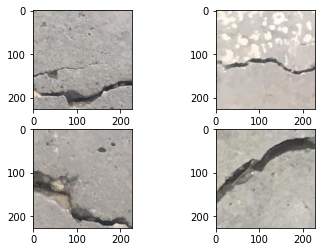

In [ ]:
## Plot some random crack images
dataset_dir = DATASET_PATH
print("Crack Images")
crack_images = os.listdir(Path(dataset_dir)/ "train" / "crack")
random_indices = np.random.randint(0, len(crack_images), size=4)
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(f'{dataset_dir}/train/crack/{random_images[0]}'))
axarr[0,1].imshow(mpimg.imread(f'{dataset_dir}/train/crack/{random_images[1]}'))
axarr[1,0].imshow(mpimg.imread(f'{dataset_dir}/train/crack/{random_images[2]}'))
axarr[1,1].imshow(mpimg.imread(f'{dataset_dir}/train/crack/{random_images[3]}'))
plt.show();

Noncrack Images


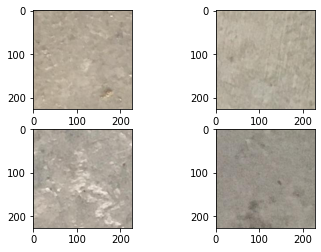

In [ ]:
## Plot some random noncrack images
dataset_dir = DATASET_PATH
print("Noncrack Images")
noncrack_images = os.listdir(Path(dataset_dir)/ "train/noncrack")
random_indices = np.random.randint(0, len(noncrack_images), size=4)
random_images = np.array(noncrack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(f'{dataset_dir}/train/noncrack/{random_images[0]}'))
axarr[0,1].imshow(mpimg.imread(f'{dataset_dir}/train/noncrack/{random_images[1]}'))
axarr[1,0].imshow(mpimg.imread(f'{dataset_dir}/train/noncrack/{random_images[2]}'))
axarr[1,1].imshow(mpimg.imread(f'{dataset_dir}/train/noncrack/{random_images[3]}'))
plt.show();

### Save Colab Dataset To Drive

**NOTE**: It can change your previous google drive dataset.

In [ ]:
if SAVE_COLAB_DATASET_TO_GOOGLE_DRIVE:
  # current colab dataset directory
  colab_dataset_path = DATASET_DIRNAME
  print(f"List inside {colab_dataset_path}:")
  print(*os.listdir(colab_dataset_path), sep='\n')

  # select location of gdrive
  gdrive_dataset_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_DATASET_PATH}'
  print(f"List inside {gdrive_dataset_path}:")
  print(*os.listdir(gdrive_dataset_path), sep='\n')

  # copy gdrive dataset to colab
  # how to : https://stackoverflow.com/q/59710439/8520849
  copytree(src=colab_dataset_path, dst=gdrive_dataset_path)

  # see copied dataset
  print(f"List inside {gdrive_dataset_path}:")
  print(*os.listdir(gdrive_dataset_path), sep='\n')

## Augmentation, transformation and data loader



We want to use data augmentation only on `train set`. We will not `test or validation set`.

We have to resize image by `224x224` which is the expected size of our transfer learning models.

All pre-trained [models](https://pytorch.org/vision/stable/models.html) expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean` = [`0.485`, `0.456`, `0.406`] and `std` = [`0.229`, `0.224`, `0.225`].

We can use the following transform to normalize:
```
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

In [ ]:
# normalize mean and std according to
# pytorch models description https://pytorch.org/vision/stable/models.html
norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# train transformation with data augmentation
train_transform = transforms.Compose([
  transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)),
  transforms.RandomRotation(degrees=15),
  transforms.ColorJitter(),
  transforms.CenterCrop(size=224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=norm_mean, std=norm_std)                
])

# test transformation without data augmentation
test_transform = transforms.Compose([
  transforms.Resize(size=227),
  transforms.CenterCrop(size=224),
  transforms.ToTensor(),
  transforms.Normalize(mean=norm_mean, std=norm_std)
])

In [ ]:
_dataset_path_dir = Path(DATASET_PATH)
train_dataset = datasets.ImageFolder(
    _dataset_path_dir / 'train',
    transform=train_transform
)
test_dataset = datasets.ImageFolder(
    _dataset_path_dir / 'test',
    transform=test_transform
)

In [ ]:
# Data loader
# Usefull because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = BATCH_SIZE

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

## Utility Functions

Some helper functions are defined in this section to reuse code and encapsulate some processes.

### Utils for Training and Validation

In [ ]:
#@title **Evaluation Method**

#@markdown  *Confusion Matrix*, *Precision*, *Recall*, *F1 Scrore*, and Validation *Accuracy* are the standard evaluation method for the classification model.

#@markdown **Confusion Matrix** as the name suggests gives us a matrix as output and describes the complete performance of the model.

#@markdown | Actual / Predicted| Positive               | Negetive               |
#@markdown | :---------------- |   :-----------------:  |  :-----------------:   |
#@markdown |  Positive         | True Positive (**TP**) | False Negetive (**FN**)|
#@markdown |  Negetive         | False Positive (**FP**)| True Negetive (**TN**) |

#@markdown **Precision** is the number of correctly identified cases among all the identified cases. 
#@markdown $$Precision, P = \frac{TP}{TP + FP}$$

#@markdown **Recall** is the number of correctly identified cases from all the positive representations. 
#@markdown $$Recall, R = \frac{TP}{TP + FN}$$

#@markdown **F1 score** is the harmonic average of precision and recall.
#@markdown $$F1Scrore, F1 = 2\times \frac{P \times R}{P + R}$$

#@markdown **Accuracy** is the ratio of number of correct predictions to the total number of input sampols.
#@markdown $$Accuracy = \frac{Number of Correct predictions}{Total number of predictions made}$$

In [ ]:
# training function
def fit(model, criterion, optimizer, dataloader, device):
  model.train()
  train_running_loss = 0.0
  train_running_correct = 0

  for inputs, targets in dataloader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # store loss and correct
    train_running_loss += loss.item()
    train_running_correct += (predictions == targets).sum().item()

    # Backward and optimize
    loss.backward()
    optimizer.step()
      
  train_loss = train_running_loss/len(dataloader.dataset)
  # train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
  train_accuracy = train_running_correct/len(dataloader.dataset)
  return train_loss, train_accuracy

In [ ]:
# validation function
def validate(model, criterion, optimizer, dataloader, device):
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0

  with torch.no_grad():
    for inputs, targets in dataloader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Get prediction
      # torch.max returns both max and argmax
      _, predictions = torch.max(outputs, 1)

      val_running_loss += loss.item()
      val_running_correct += (predictions == targets).sum().item()
    
    val_loss = val_running_loss/len(dataloader.dataset)
    # val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
    val_accuracy = val_running_correct/len(dataloader.dataset)        
    return val_loss, val_accuracy

In [ ]:
# training function
def train_and_validate(model, 
                       criterion, 
                       optimizer, 
                       train_loader, 
                       test_loader, 
                       device, 
                       epochs):
  train_loss , train_accuracy = [], []
  val_loss, val_accuracy = [], []
  for epoch in range(epochs):
    t0 = datetime.now()
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = \
                    fit(model, criterion, optimizer, train_loader, device)
    val_epoch_loss, val_epoch_accuracy = \
                    validate(model, criterion, optimizer, test_loader, device)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)

    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    dt = datetime.now() - t0

    print(f"Train Loss: {train_epoch_loss:.6f}, Train Acc: {train_epoch_accuracy:.6f}")
    print(f"Val Loss: {val_epoch_loss:.6f}, Val Acc: {val_epoch_accuracy:.6f}")
    print(f"Duration: {dt}")
  return train_loss , train_accuracy, val_loss, val_accuracy

### Utils to Plot History and Save Images

In [ ]:
# A function to plot train and val loss
def plot_loss(train_loss, 
              val_loss, 
              train_label='train loss', 
              val_label='val loss',
              title="",
              xlabel="",
              ylabel="",
              save=False,
              save_path=None):
  plt.plot(train_loss, label=train_label)
  plt.plot(val_loss, label=val_label)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  if save and save_path:
    try:
      plt.savefig(save_path)
    except Exception as e:
      print("Figure save failed!")
      raise e
  plt.show()

# A function to plot train and val accuracy
def plot_accuracy(train_acuracy, 
              val_acuracy, 
              train_label='train accuracy', 
              val_label='val accuracy',
              title="",
              xlabel="",
              ylabel="",
              save=False,
              save_path=None):
  plt.plot(train_acuracy, label=train_label)
  plt.plot(val_acuracy, label=val_label)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  if save and save_path:
    try:
      plt.savefig(save_path)
    except Exception as e:
      print("Figure save failed!")
      raise e
  plt.show()

In [ ]:
def plot_show_save(data, color, title, xlabel, ylabel, file_path, figsize=(10, 7)):
  plt.figure(figsize=figsize)
  plt.plot(data, color=color, label=title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(file_path)
  plt.show();

### Utils to Save Model Checkpoint

In [ ]:
# A function to save model checkpoint
def save_model_checkpoint(model_name, 
                          model, 
                          criterion, 
                          optimizer, 
                          epochs, 
                          batch_size,
                          train_history,
                          validation_history,
                          file_name,
                          destination=None, 
                          overwrite=False):
  if  destination:
    file_path = Path(destination)/ f"{file_name}.pth"
  else:
    file_path = Path(f"{file_name}.pth")
  
  if (not overwrite) and file_path.exists():
    print(f"File '{file_path}' already exist.")
    file_path = file_path[:-4] + f"{str(datetime.now())}" + '.pth'
    print(f"File renamed with current datetime as '{file_path}'")
  try:
    if destination and (not Path(destination).exists()):
      Path(destination).mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), file_path)
    torch.save({
            'model_name': model_name,
            'batch_size': batch_size,
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            'train_history': train_history,
            'validation_history': validation_history,
            }, file_path)
    print(f"Model checkpoint saved at '{file_path}'")
  except Exception as e:
    print(f"Model checkpoint did not save!")
    raise(e)
    return
  return file_path

# A function that convert loss, accuracy list to dictionary
# It is usefull during save model checkpoint
def prepare_history_dict(loss, accuracy):
  loss_d = {k:v for k, v in enumerate(loss)}
  accuracy = {k:v for k, v in enumerate(accuracy)}
  history = {
      'loss': loss_d,
      'accuracy': accuracy
  }
  return history

# A function that convert history dictionary to loss, accuracy list
# It is usefull during load saved model checkpoint
def retrieve_history_list(history):
  loss = [history['loss'][i] for i in range(len(history['loss']))]
  accuracy = [history['accuracy'][i] for i in range(len(history['accuracy']))]
  return loss, accuracy

# A function to load saved model checkpoint
def load_model_checkpoint(saved_model_checkpoint_path):
  # load the model checkpoint
  checkpoint = torch.load(saved_model_checkpoint_path)
  return checkpoint

### Utils to Show State Dict

In [ ]:
# A function to print model and/or optimizer state_dict
def print_state_dict(model=None, optimizer=None):
  # model's state_dict
  if model:
    print("model's state_dict:")
    for param_tensor in model.state_dict():
      print(f"{param_tensor} \t {model.state_dict()[param_tensor].size()}")
  if optimizer:
    # optimizer's state_dict
    print("optimizer's state_dict:")
    for var_name in optimizer.state_dict():
      print(f"{var_name} \t {optimizer.state_dict()[var_name]}")
  if not (model and optimizer):
    print("No model or optimizer provided. Skipping!")


# Model Construction for Initial Trainig

**NOTE**: This block may not need during *`Resume Training`*

## Define transfer learning models

We are going to apply transfer learning technique based on the following models:


*   [VGG](https://arxiv.org/abs/1409.1556)
*   [ResNet](https://arxiv.org/abs/1512.03385)
*   [DenseNet](https://arxiv.org/abs/1608.06993)
*   [AlexNet](https://arxiv.org/abs/1404.5997)


### VGG

Prepare VGG model for transfer learning.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # pretrained vgg16 model
  model_vgg16 = models.vgg16(pretrained=True)

  # Freeze weights
  for param in model_vgg16.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_vgg16)

  # We want to replace the 'classifier'
  print(model_vgg16.classifier)

  # see the number of features
  n_features_vgg16 = model_vgg16.classifier[0].in_features
  print(n_features_vgg16)

  # We're doing binary classification
  model_vgg16.classifier = nn.Linear(n_features_vgg16, 2)

  # Let's see what the model is now
  print("Customized Model")
  print(model_vgg16)

  # Use GPU if available
  print(device)
  model_vgg16.to(device)

  # Loss and optimizer
  criterion_vgg16 = nn.CrossEntropyLoss()
  optimizer_vgg16 = torch.optim.Adam(model_vgg16.parameters())

### ResNet

Prepare ResNet model for transfer learning.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # pretrained resnet18 model
  model_resnet18 = models.resnet18(pretrained=True)

  # Freeze weights
  for param in model_resnet18.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_resnet18)

  # We want to replace the 'fc'
  print(model_resnet18.fc)

  # see the number of features
  n_features_resnet18 = model_resnet18.fc.in_features
  print(n_features_resnet18)

  # We're doing binary classification
  model_resnet18.fc = nn.Linear(n_features_resnet18, 2)

  # Let's see what the model is now
  print("Customized Model")
  print(model_resnet18)

  # Use GPU if available
  print(device)
  model_resnet18.to(device)

  # Loss and optimizer
  criterion_resnet18 = nn.CrossEntropyLoss()
  optimizer_resnet18 = torch.optim.Adam(model_resnet18.parameters())

### DenseNet

Prepare DenseNet model for transfer learning.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # pretrained densenet161 model
  model_densenet161 = models.densenet161(pretrained=True)

  # Freeze weights
  for param in model_densenet161.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_densenet161)

  # We want to replace the 'classifier'
  print(model_densenet161.classifier)

  # see the number of features
  n_features_densenet161 = model_densenet161.classifier.in_features
  print(n_features_densenet161)

  # We're doing binary classification
  model_densenet161.classifier = nn.Linear(n_features_densenet161, 2)

  # Let's see what the model is now
  print("Customized Model")
  print(model_densenet161)

  # Use GPU if available
  print(device)
  model_densenet161.to(device)

  # Loss and optimizer
  criterion_densenet161 = nn.CrossEntropyLoss()
  optimizer_densenet161 = torch.optim.Adam(model_densenet161.parameters())

### AlexNet

Prepare AlexNet model for transfer learning.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # pretrained alexnet model
  model_alexnet = models.alexnet(pretrained=True)

  # Freeze weights
  for param in model_alexnet.parameters():
    param.requires_grad = False

  # see model detail
  print("Pretrained Model")
  print(model_alexnet)

  # We want to replace the 'classifier'
  print(model_alexnet.classifier)

  # see the number of features
  n_features_alexnet = model_alexnet.classifier[1].in_features
  print(n_features_alexnet)

  # We're doing binary classification
  model_alexnet.classifier = nn.Linear(n_features_alexnet, 2)

  # Let's see what the model is now
  print("Customized Model")
  print(model_alexnet)

  # Use GPU if available
  print(device)
  model_alexnet.to(device)

  # Loss and optimizer
  criterion_alexnet = nn.CrossEntropyLoss()
  optimizer_alexnet = torch.optim.Adam(model_alexnet.parameters())

# Ininitial Training Block

**NOTE**: This block of cells may not required during *`Resume Training`*

## Train and Evaluate Models



In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # Some common variables
  epochs = INITIAL_TRAINING_EPOCHS

### VGG

In [ ]:
# train the model
if ACTIVE_INITIAL_TRAINING_STAGE:
  epochs_vgg16 = epochs

  train_loss_vgg16, train_accuracy_vgg16, val_loss_vgg16, val_accuracy_vgg16 = train_and_validate(
            model=model_vgg16, 
            criterion=criterion_vgg16, 
            optimizer=optimizer_vgg16, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            device=device, 
            epochs=epochs_vgg16)

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # plot train and val loss
  plot_loss(train_loss=train_loss_vgg16, 
            val_loss=val_loss_vgg16, 
            train_label='train loss', 
            val_label='val loss',
            title="vgg16",
            xlabel="Epoch",
            ylabel="Loss",
            save=False,
            save_path=None)

  # plot train and val accuracy
  plot_accuracy(train_acuracy=train_accuracy_vgg16, 
                val_acuracy=val_accuracy_vgg16, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="vgg16",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=False,
                save_path=None)

### ResNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  epochs_resnet18 = epochs

  train_loss_resnet18, train_accuracy_resnet18, val_loss_resnet18, val_accuracy_resnet18 = train_and_validate(
            model=model_resnet18, 
            criterion=criterion_resnet18, 
            optimizer=optimizer_resnet18, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            device=device, 
            epochs=epochs_resnet18)

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # plot train and val loss
  plot_loss(train_loss=train_loss_resnet18, 
            val_loss=val_loss_resnet18, 
            train_label='train loss', 
            val_label='val loss',
            title="resnet18",
            xlabel="Epoch",
            ylabel="Loss",
            save=False,
            save_path=None)

  # plot train and val accuracy
  plot_accuracy(train_acuracy=train_accuracy_resnet18, 
                val_acuracy=val_accuracy_resnet18, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="resnet18",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=False,
                save_path=None)

### DenseNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  epochs_densenet161 = epochs

  train_loss_densenet161, train_accuracy_densenet161, val_loss_densenet161, val_accuracy_densenet161 = train_and_validate(
            model=model_densenet161, 
            criterion=criterion_densenet161, 
            optimizer=optimizer_densenet161, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            device=device, 
            epochs=epochs_densenet161)

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # plot train and val loss
  plot_loss(train_loss=train_loss_densenet161, 
            val_loss=val_loss_densenet161, 
            train_label='train loss', 
            val_label='val loss',
            title="densenet161",
            xlabel="Epoch",
            ylabel="Loss",
            save=False,
            save_path=None)

  # plot train and val accuracy
  plot_accuracy(train_acuracy=train_accuracy_densenet161, 
                val_acuracy=val_accuracy_densenet161, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="densenet161",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=False,
                save_path=None)

### AlexNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  epochs_alexnet = epochs

  train_loss_alexnet, train_accuracy_alexnet, val_loss_alexnet, val_accuracy_alexnet = train_and_validate(
            model=model_alexnet, 
            criterion=criterion_alexnet, 
            optimizer=optimizer_alexnet, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            device=device, 
            epochs=epochs_alexnet)

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # plot train and val loss
  plot_loss(train_loss=train_loss_alexnet, 
            val_loss=val_loss_alexnet, 
            train_label='train loss', 
            val_label='val loss',
            title="alexnet",
            xlabel="Epoch",
            ylabel="Loss",
            save=False,
            save_path=None)

  # plot train and val accuracy
  plot_accuracy(train_acuracy=train_accuracy_alexnet, 
                val_acuracy=val_accuracy_alexnet, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="alexnet",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=False,
                save_path=None)

## Save and Download Models

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # common variables for saving and retrieving models
  saved_model_list = {}
  saved_model_destination = MODELS_DIRNAME_COLAB

### VGG

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  checkpoint_file_name_vgg16= f'vgg16-epochs-{epochs_vgg16}-{datetime.now()}'
  train_history_vgg16 = prepare_history_dict(loss=train_loss_vgg16, 
                                            accuracy=train_accuracy_vgg16)
  validation_history_vgg16 = prepare_history_dict(loss=val_loss_vgg16, 
                                                  accuracy=val_accuracy_vgg16)
  model_path_vgg16 = save_model_checkpoint(
                        model_name='vgg16', 
                        model=model_vgg16, 
                        criterion=criterion_vgg16, 
                        optimizer=optimizer_vgg16, 
                        epochs=epochs_vgg16, 
                        batch_size=batch_size,
                        train_history=train_history_vgg16,
                        validation_history=validation_history_vgg16,
                        file_name=checkpoint_file_name_vgg16,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_vgg16:
    saved_model_list['vgg16'] = model_path_vgg16
  else:
    raise Exception("Error: Model did not saved succesfully!")

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # see list of saved models
  print(*os.listdir(saved_model_destination), sep='\n')

### ResNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  checkpoint_file_name_resnet18= f'resnet18-epochs-{epochs_resnet18}-{datetime.now()}'
  train_history_resnet18 = prepare_history_dict(loss=train_loss_resnet18, 
                                            accuracy=train_accuracy_resnet18)
  validation_history_resnet18 = prepare_history_dict(loss=val_loss_resnet18, 
                                                  accuracy=val_accuracy_resnet18)
  model_path_resnet18 = save_model_checkpoint(
                        model_name='resnet18', 
                        model=model_resnet18, 
                        criterion=criterion_resnet18, 
                        optimizer=optimizer_resnet18, 
                        epochs=epochs_resnet18, 
                        batch_size=batch_size,
                        train_history=train_history_resnet18,
                        validation_history=validation_history_resnet18,
                        file_name=checkpoint_file_name_resnet18,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_resnet18:
    saved_model_list['resnet18'] = model_path_resnet18
  else:
    raise Exception("Error: Model did not saved succesfully!")

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # see list of saved models
  print(*os.listdir(saved_model_destination), sep='\n')

### DenseNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  checkpoint_file_name_densenet161= f'densenet161-epochs-{epochs_densenet161}-{datetime.now()}'
  train_history_densenet161 = prepare_history_dict(loss=train_loss_densenet161, 
                                            accuracy=train_accuracy_densenet161)
  validation_history_densenet161 = prepare_history_dict(loss=val_loss_densenet161, 
                                                  accuracy=val_accuracy_densenet161)
  model_path_densenet161 = save_model_checkpoint(
                        model_name='densenet161', 
                        model=model_densenet161, 
                        criterion=criterion_densenet161, 
                        optimizer=optimizer_densenet161, 
                        epochs=epochs_densenet161, 
                        batch_size=batch_size,
                        train_history=train_history_densenet161,
                        validation_history=validation_history_densenet161,
                        file_name=checkpoint_file_name_densenet161,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_densenet161:
    saved_model_list['densenet161'] = model_path_densenet161
  else:
    raise Exception("Error: Model did not saved succesfully!")

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # see list of saved models
  print(*os.listdir(saved_model_destination), sep='\n')

### AlexNet

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  checkpoint_file_name_alexnet= f'alexnet-epochs-{epochs_alexnet}-{datetime.now()}'
  train_history_alexnet = prepare_history_dict(loss=train_loss_alexnet, 
                                            accuracy=train_accuracy_alexnet)
  validation_history_alexnet = prepare_history_dict(loss=val_loss_alexnet, 
                                                  accuracy=val_accuracy_alexnet)
  model_path_alexnet = save_model_checkpoint(
                        model_name='alexnet', 
                        model=model_alexnet, 
                        criterion=criterion_alexnet, 
                        optimizer=optimizer_alexnet, 
                        epochs=epochs_alexnet, 
                        batch_size=batch_size,
                        train_history=train_history_alexnet,
                        validation_history=validation_history_alexnet,
                        file_name=checkpoint_file_name_alexnet,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_alexnet:
    saved_model_list['alexnet'] = model_path_alexnet
  else:
    raise Exception("Error: Model did not saved succesfully!")

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # see list of saved models
  print(*os.listdir(saved_model_destination), sep='\n')

### Save Models to Google Drive


In [ ]:
if SAVE_MODELS_TO_GOOGLE_DRIVE and ACTIVE_INITIAL_TRAINING_STAGE:
  # see inside gdrive
  os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME)
  # select location of gdrive
  gdrive_models_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_MODELS_PATH}'
  os.listdir(gdrive_models_path)

  # copy colab models to gdrive
  # how to : https://stackoverflow.com/q/59710439/8520849
  # !cp -av 'models' 'gdrive/MyDrive/ML/concrete_crack_detection/models'
  # os.system("cp -av {} {}".format(saved_model_destination, gdrive_models_path))
  copytree(src=saved_model_destination, dst=gdrive_models_path)

### Download Saved Models Localy

All saved models should be `models` directory.
Download the `models` directory localy.

In [ ]:
if ACTIVE_INITIAL_TRAINING_STAGE:
  # check saved models inside `models` directory
  try:
    print(*os.listdir(saved_model_destination), sep="\n")
  except Exception as e:
    print(e)

In [ ]:
# Download models localy
if DOWNLOAD_SAVED_MODELS_LOCALY and ACTIVE_INITIAL_TRAINING_STAGE:
  from google.colab import files
  dir_to_zip = saved_model_destination
  output_filename = 'models.zip'
  os.system("zip -r {} {}".format(output_filename, dir_to_zip))
  files.download(output_filename)

# Resume Training Block

**NOTE**: This block of cells able to resume train from last saved models checkpoint (last learge epochs). It is super usefull for for trainig models large number of epochs.

## Access Saved Models



In [ ]:
loaded_models_from_gdrive_path = 'models_gdrive'
loaded_models_from_local_path = 'models_local'

### Access Models from Google Drive

In [ ]:
if LOAD_MODELS_FROM_GOOGLE_DRIVE:
  # select location of gdrive
  gdrive_models_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_MODELS_PATH}'
  print(f"List inside {gdrive_models_path}:")
  print(*os.listdir(gdrive_models_path), sep='\n')

  # copy gdrive models to colab
  # how to : https://stackoverflow.com/q/59710439/8520849
  copytree(src=gdrive_models_path, dst=loaded_models_from_gdrive_path)

  # see loaded models
  print(f"List inside {loaded_models_from_gdrive_path}:")
  print(*os.listdir(loaded_models_from_gdrive_path), sep='\n')

List inside gdrive/MyDrive/ML/concrete-crack-detection/models:
resnet18-epochs-1-2021-10-23 05:30:52.401421.pth
vgg16-epochs-1-2021-10-23 05:30:52.132006.pth
densenet161-epochs-1-2021-10-23 05:30:52.647853.pth
alexnet-epochs-1-2021-10-23 05:30:53.656397.pth
vgg16-epochs-7-10_23_2021_11_09_24.pth
resnet18-epochs-7-10_23_2021_11_16_24.pth
densenet161-epochs-7-10_23_2021_11_42_42.pth
alexnet-epochs-7-10_23_2021_11_48_27.pth
alexnet-epochs-5-10_23_2021_10_26_28.pth
resnet18-epochs-5-10_23_2021_09_54_36.pth
alexnet-epochs-3-10_23_2021_09_07_21.pth
vgg16-epochs-3-10_23_2021_08_28_17.pth
densenet161-epochs-5-10_23_2021_10_20_42.pth
resnet18-epochs-3-10_23_2021_08_35_27.pth
vgg16-epochs-5-10_23_2021_09_47_32.pth
densenet161-epochs-3-10_23_2021_09_01_35.pth
vgg16-epochs-9-10_23_2021_13_22_24.pth
resnet18-epochs-9-10_23_2021_13_29_29.pth
densenet161-epochs-9-10_23_2021_13_56_53.pth
alexnet-epochs-9-10_23_2021_14_02_29.pth
vgg16-epochs-21-10_23_2021_19_33_36.pth
resnet18-epochs-21-10_23_2021_19_4

### Access Models from local machine

In [ ]:
# Upload models from local machine 
# Uploading from local machine takes more times than google drive
# and some extra work required after upload completed
from google.colab import files
if LOAD_MODELS_FROM_LOCAL:
  # loaded_models_from_local_path
  uploaded = files.upload()

In [ ]:
if LOAD_MODELS_FROM_LOCAL:
  pass
  # # preprocess models if needed
  # for fn in uploaded.keys():
  #   # print('User uploaded file "{name}" with length {length} bytes'.format(
  #   #     name=fn, length=len(uploaded[fn])))
  #   print(fn)
  # # os.system("unzip -qq -o {} -d {}".format(uploaded, loaded_models_from_local_path))
  # # print(*os.listdir(loaded_models_from_local_path), sep='\n')

In [ ]:
# see uploaded models
if LOAD_MODELS_FROM_LOCAL:
  os.listdir(*loaded_models_from_local_path, sep='\n')

## Resume Training and Validation

### Validate and Get Best Checkpoints

In [ ]:
# default retrieved_saved_models_dir
retrieved_saved_models_dir = MODELS_DIRNAME_COLAB
model_checkpoint_file_names = []
model_checkpoint_path_dict = {}
valid_model_names = [
                    'vgg16',
                    'resnet18',
                    'densenet161',
                    'alexnet']
new_epochs = RESUME_TRAINING_EPOCHS
# If we want to train where the last trained epochs
RESUME_TRAIN = RESUME_TRAINING_STAGE

# common variables for saving and retrieving models
saved_model_list = {}
saved_model_destination = MODELS_DIRNAME_COLAB

# common variables for saving logs or images or text files
logs_destination = LOGS_DIRNAME
# create logs_destination if not exists
if not os.path.exists(logs_destination):
  os.makedirs(logs_destination)

In [ ]:
if LOAD_MODELS_FROM_GOOGLE_DRIVE or LOAD_MODELS_FROM_LOCAL:
  if LOAD_MODELS_FROM_GOOGLE_DRIVE:
    retrieved_saved_models_dir = loaded_models_from_gdrive_path
  elif LOAD_MODELS_FROM_LOCAL:
    retrieved_saved_models_dir = loaded_models_from_local_path
else:
  retrieved_saved_models_dir = saved_model_destination

In [ ]:
# see the available models and 
# store pathe in a dictionary manualy or automatic
model_checkpoint_file_names = os.listdir(retrieved_saved_models_dir)
for file_name in model_checkpoint_file_names:
  extension = file_name.split('.')[-1]
  if not extension == 'pth':
    continue
  
  model_name = file_name.split('-')[0]
  if model_name in valid_model_names:
    if model_checkpoint_path_dict.get(model_name, None):
      try:
        pre_file_name = str(model_checkpoint_path_dict[model_name]).split('/')[-1]
        pre_epochs = int(pre_file_name.split('-')[2]) # "<modelname>-epochs-<epochs>-....pth"
        curr_epochs = int(file_name.split('-')[2]) # "<modelname>-epochs-<epochs>-....pth"
        if curr_epochs > pre_epochs:
          model_checkpoint_path_dict[model_name] = Path(retrieved_saved_models_dir) / f'{file_name}'
      except Exception as e:
        print("ERROR: saved models file name convension mismatch.")
        print("Sould be like '<modelname>-epochs-<epochs>-....pth'")
    else:
      model_checkpoint_path_dict[model_name] = Path(retrieved_saved_models_dir) / f'{file_name}'
if len(model_checkpoint_path_dict) > 0:
  print(f"{len(model_checkpoint_path_dict)} model checkpoint found.")
  print(f"Models Name: {model_checkpoint_path_dict.keys()}")
  print(*model_checkpoint_path_dict.items(), sep='\n')
else:
  print(f"WARNING: No model checkpoint found!")

4 model checkpoint found.
Models Name: dict_keys(['densenet161', 'resnet18', 'vgg16', 'alexnet'])
('densenet161', PosixPath('models_gdrive/densenet161-epochs-29-10_24_2021_02_04_30.pth'))
('resnet18', PosixPath('models_gdrive/resnet18-epochs-29-10_24_2021_01_36_47.pth'))
('vgg16', PosixPath('models_gdrive/vgg16-epochs-29-10_24_2021_01_28_51.pth'))
('alexnet', PosixPath('models_gdrive/alexnet-epochs-29-10_24_2021_02_10_13.pth'))


### VGG

In [ ]:
# Load Saved Model Checkpoint
if model_checkpoint_path_dict.get('vgg16', None) is not None:
  # pretrained vgg16 model
  model_vgg16 = models.vgg16(pretrained=True)

  # Freeze weights
  for param in model_vgg16.parameters():
    param.requires_grad = False
  
  # see the number of features
  n_features_vgg16 = model_vgg16.classifier[0].in_features
  print(n_features_vgg16)

  # We're doing binary classification
  model_vgg16.classifier = nn.Linear(n_features_vgg16, 2)

  # Use GPU if available
  print(device)
  model_vgg16.to(device)

  # Loss and optimizer
  criterion_vgg16 = nn.CrossEntropyLoss()
  optimizer_vgg16 = torch.optim.Adam(model_vgg16.parameters())

  # load the model checkpoint
  checkpoint_vgg16 = load_model_checkpoint(
                      model_checkpoint_path_dict.get('vgg16'))

  # load model weights state_dict
  model_vgg16.load_state_dict(checkpoint_vgg16['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer_vgg16.load_state_dict(checkpoint_vgg16['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  # Previous epochs
  epochs_vgg16_pre = checkpoint_vgg16['epoch']
  print(f"Previously trained for {epochs_vgg16_pre} number of epochs...")

  # load the criterion
  criterion_vgg16 = checkpoint_vgg16['loss']
  print('Trained model loss function loaded...')

  train_loss_vgg16_pre, train_accuracy_vgg16_pre = retrieve_history_list(
                                checkpoint_vgg16['train_history'])
  val_loss_vgg16_pre, val_accuracy_vgg16_pre = retrieve_history_list(
                                checkpoint_vgg16['validation_history'])

25088
cuda:0
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 29 number of epochs...
Trained model loss function loaded...


In [ ]:
# Resume Training
if model_checkpoint_path_dict.get('vgg16', None) and RESUME_TRAIN:
  # train for more epochs
  epochs_vgg16_new = new_epochs
  print(f"Train for {epochs_vgg16_new} more epochs...")

  # resume train
  train_loss_vgg16_new, train_accuracy_vgg16_new, val_loss_vgg16_new, \
  val_accuracy_vgg16_new = train_and_validate(
        model=model_vgg16, 
        criterion=criterion_vgg16, 
        optimizer=optimizer_vgg16, 
        train_loader=train_loader, 
        test_loader=test_loader, 
        device=device, 
        epochs=epochs_vgg16_new)
  
  # togather all things
  train_loss_vgg16_all = train_loss_vgg16_pre + train_loss_vgg16_new
  train_accuracy_vgg16_all = train_accuracy_vgg16_pre \
                              + train_accuracy_vgg16_new
  val_loss_vgg16_all = val_loss_vgg16_pre + val_loss_vgg16_new
  val_accuracy_vgg16_all = val_accuracy_vgg16_pre + val_accuracy_vgg16_new
  epochs_vgg16_all = epochs_vgg16_pre + epochs_vgg16_new

Train for 1 more epochs...
Epoch 1 of 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Loss: 0.000098, Train Acc: 0.997625
Val Loss: 0.000122, Val Acc: 0.998125
Duration: 0:08:46.729322


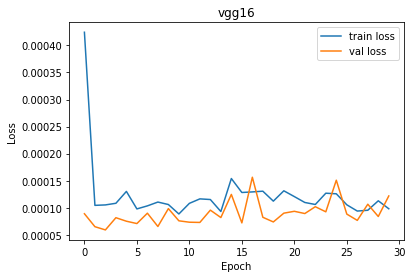

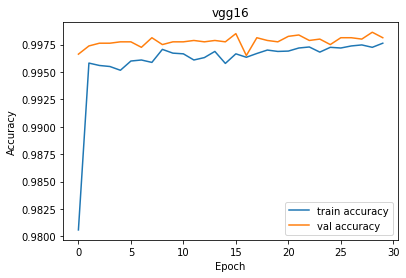

In [ ]:
# Plot and save logs of train and val loss-accuracy
if model_checkpoint_path_dict.get('vgg16', None) and RESUME_TRAIN:
  # plot train and val loss
  fig_path = Path(logs_destination) / \
      f"vgg16-epochs-{epochs_vgg16_all}-loss-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_loss(train_loss=train_loss_vgg16_all, 
            val_loss=val_loss_vgg16_all, 
            train_label='train loss', 
            val_label='val loss',
            title="vgg16",
            xlabel="Epoch",
            ylabel="Loss",
            save=True,
            save_path=fig_path)

  # plot train and val accuracy
  fig_path = Path(logs_destination) / \
      f"vgg16-epochs-{epochs_vgg16_all}-accuracy-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_accuracy(train_acuracy=train_accuracy_vgg16_all, 
                val_acuracy=val_accuracy_vgg16_all, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="vgg16",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=True,
                save_path=fig_path)

In [ ]:
# Save Latest Training Checkpoint Again 
if model_checkpoint_path_dict.get('vgg16', None) and RESUME_TRAIN:
  # save model checkpoint again
  checkpoint_file_name_vgg16= \
                  f"vgg16-epochs-{epochs_vgg16_all}-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}"
  train_history_vgg16_all = \
                  prepare_history_dict(loss=train_loss_vgg16_all, 
                                      accuracy=train_accuracy_vgg16_all)
  validation_history_vgg16_all = \
                  prepare_history_dict(loss=val_loss_vgg16_all, 
                                      accuracy=val_accuracy_vgg16_all)
  
  model_path_vgg16 = save_model_checkpoint(
                        model_name='vgg16', 
                        model=model_vgg16, 
                        criterion=criterion_vgg16, 
                        optimizer=optimizer_vgg16, 
                        epochs=epochs_vgg16_all, 
                        batch_size=batch_size,
                        train_history=train_history_vgg16_all,
                        validation_history=validation_history_vgg16_all,
                        file_name=checkpoint_file_name_vgg16,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_vgg16:
    saved_model_list['vgg16'] = model_path_vgg16
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'models/vgg16-epochs-30-10_24_2021_02_28_26.pth'


### ResNet

In [ ]:
# Load Saved Model Checkpoint
if model_checkpoint_path_dict.get('resnet18', None) is not None:
  # pretrained resnet18 model
  model_resnet18 = models.resnet18(pretrained=True)

  # Freeze weights
  for param in model_resnet18.parameters():
    param.requires_grad = False
  
  # see the number of features
  n_features_resnet18 = model_resnet18.fc.in_features
  print(n_features_resnet18)

  # We're doing binary classification
  model_resnet18.fc = nn.Linear(n_features_resnet18, 2)

  # Use GPU if available
  print(device)
  model_resnet18.to(device)

  # Loss and optimizer
  criterion_resnet18 = nn.CrossEntropyLoss()
  optimizer_resnet18 = torch.optim.Adam(model_resnet18.parameters())

  # load the model checkpoint
  checkpoint_resnet18 = load_model_checkpoint(
                      model_checkpoint_path_dict.get('resnet18'))

  # load model weights state_dict
  model_resnet18.load_state_dict(checkpoint_resnet18['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer_resnet18.load_state_dict(checkpoint_resnet18['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  # Previous epochs
  epochs_resnet18_pre = checkpoint_resnet18['epoch']
  print(f"Previously trained for {epochs_resnet18_pre} number of epochs...")

  # load the criterion
  criterion_resnet18 = checkpoint_resnet18['loss']
  print('Trained model loss function loaded...')

  train_loss_resnet18_pre, train_accuracy_resnet18_pre = retrieve_history_list(
                                checkpoint_resnet18['train_history'])
  val_loss_resnet18_pre, val_accuracy_resnet18_pre = retrieve_history_list(
                                checkpoint_resnet18['validation_history'])

512
cuda:0
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 29 number of epochs...
Trained model loss function loaded...


In [ ]:
# Resume Training
if model_checkpoint_path_dict.get('resnet18', None) and RESUME_TRAIN:
  # train for more epochs
  epochs_resnet18_new = new_epochs
  print(f"Train for {epochs_resnet18_new} more epochs...")

  # resume train
  train_loss_resnet18_new, train_accuracy_resnet18_new, val_loss_resnet18_new, \
  val_accuracy_resnet18_new = train_and_validate(
        model=model_resnet18, 
        criterion=criterion_resnet18, 
        optimizer=optimizer_resnet18, 
        train_loader=train_loader, 
        test_loader=test_loader, 
        device=device, 
        epochs=epochs_resnet18_new)
  
  # togather all things
  train_loss_resnet18_all = train_loss_resnet18_pre + train_loss_resnet18_new
  train_accuracy_resnet18_all = train_accuracy_resnet18_pre \
                              + train_accuracy_resnet18_new
  val_loss_resnet18_all = val_loss_resnet18_pre + val_loss_resnet18_new
  val_accuracy_resnet18_all = val_accuracy_resnet18_pre + val_accuracy_resnet18_new
  epochs_resnet18_all = epochs_resnet18_pre + epochs_resnet18_new

Train for 1 more epochs...
Epoch 1 of 1
Train Loss: 0.000232, Train Acc: 0.990000
Val Loss: 0.000150, Val Acc: 0.993251
Duration: 0:03:35.636223


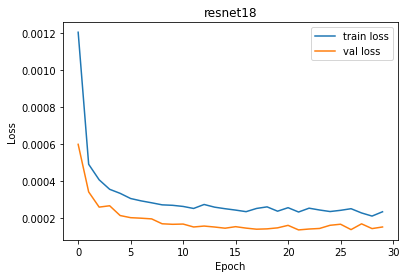

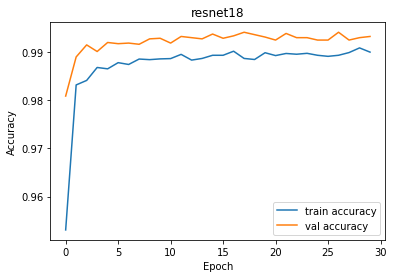

In [ ]:
# Plot and save logs of train and val loss-accuracy
if model_checkpoint_path_dict.get('resnet18', None) and RESUME_TRAIN:
  # plot train and val loss
  fig_path = Path(logs_destination) / \
      f"resnet18-epochs-{epochs_resnet18_all}-loss-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_loss(train_loss=train_loss_resnet18_all, 
            val_loss=val_loss_resnet18_all, 
            train_label='train loss', 
            val_label='val loss',
            title="resnet18",
            xlabel="Epoch",
            ylabel="Loss",
            save=True,
            save_path=fig_path)

  # plot train and val accuracy
  fig_path = Path(logs_destination) / \
      f"resnet18-epochs-{epochs_resnet18_all}-accuracy-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_accuracy(train_acuracy=train_accuracy_resnet18_all, 
                val_acuracy=val_accuracy_resnet18_all, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="resnet18",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=True,
                save_path=fig_path)

In [ ]:
# Save Latest Training Checkpoint Again 
if model_checkpoint_path_dict.get('resnet18', None) and RESUME_TRAIN:
  # save model checkpoint again
  checkpoint_file_name_resnet18= \
                  f"resnet18-epochs-{epochs_resnet18_all}-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}"
  train_history_resnet18_all = \
                  prepare_history_dict(loss=train_loss_resnet18_all, 
                                      accuracy=train_accuracy_resnet18_all)
  validation_history_resnet18_all = \
                  prepare_history_dict(loss=val_loss_resnet18_all, 
                                      accuracy=val_accuracy_resnet18_all)
  
  model_path_resnet18 = save_model_checkpoint(
                        model_name='resnet18', 
                        model=model_resnet18, 
                        criterion=criterion_resnet18, 
                        optimizer=optimizer_resnet18, 
                        epochs=epochs_resnet18_all, 
                        batch_size=batch_size,
                        train_history=train_history_resnet18_all,
                        validation_history=validation_history_resnet18_all,
                        file_name=checkpoint_file_name_resnet18,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_resnet18:
    saved_model_list['resnet18'] = model_path_resnet18
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'models/resnet18-epochs-30-10_24_2021_02_32_04.pth'


### DenseNet

In [ ]:
# Load Saved Model Checkpoint
if model_checkpoint_path_dict.get('densenet161', None) is not None:
  # pretrained densenet161 model
  model_densenet161 = models.densenet161(pretrained=True)

  # Freeze weights
  for param in model_densenet161.parameters():
    param.requires_grad = False
  
  # see the number of features
  n_features_densenet161 = model_densenet161.classifier.in_features
  print(n_features_densenet161)

  # We're doing binary classification
  model_densenet161.classifier = nn.Linear(n_features_densenet161, 2)

  # Use GPU if available
  print(device)
  model_densenet161.to(device)

  # Loss and optimizer
  criterion_densenet161 = nn.CrossEntropyLoss()
  optimizer_densenet161 = torch.optim.Adam(model_densenet161.parameters())

  # load the model checkpoint
  checkpoint_densenet161 = load_model_checkpoint(
                      model_checkpoint_path_dict.get('densenet161'))

  # load model weights state_dict
  model_densenet161.load_state_dict(checkpoint_densenet161['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer_densenet161.load_state_dict(checkpoint_densenet161['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  # Previous epochs
  epochs_densenet161_pre = checkpoint_densenet161['epoch']
  print(f"Previously trained for {epochs_densenet161_pre} number of epochs...")

  # load the criterion
  criterion_densenet161 = checkpoint_densenet161['loss']
  print('Trained model loss function loaded...')

  train_loss_densenet161_pre, train_accuracy_densenet161_pre = retrieve_history_list(
                                checkpoint_densenet161['train_history'])
  val_loss_densenet161_pre, val_accuracy_densenet161_pre = retrieve_history_list(
                                checkpoint_densenet161['validation_history'])

2208
cuda:0
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 29 number of epochs...
Trained model loss function loaded...


In [ ]:
# Resume Training
if model_checkpoint_path_dict.get('densenet161', None) and RESUME_TRAIN:
  # train for more epochs
  epochs_densenet161_new = new_epochs
  print(f"Train for {epochs_densenet161_new} more epochs...")

  # resume train
  train_loss_densenet161_new, train_accuracy_densenet161_new, val_loss_densenet161_new, \
  val_accuracy_densenet161_new = train_and_validate(
        model=model_densenet161, 
        criterion=criterion_densenet161, 
        optimizer=optimizer_densenet161, 
        train_loader=train_loader, 
        test_loader=test_loader, 
        device=device, 
        epochs=epochs_densenet161_new)
  
  # togather all things
  train_loss_densenet161_all = train_loss_densenet161_pre + train_loss_densenet161_new
  train_accuracy_densenet161_all = train_accuracy_densenet161_pre \
                              + train_accuracy_densenet161_new
  val_loss_densenet161_all = val_loss_densenet161_pre + val_loss_densenet161_new
  val_accuracy_densenet161_all = val_accuracy_densenet161_pre + val_accuracy_densenet161_new
  epochs_densenet161_all = epochs_densenet161_pre + epochs_densenet161_new

Train for 1 more epochs...
Epoch 1 of 1
Train Loss: 0.000145, Train Acc: 0.994219
Val Loss: 0.000080, Val Acc: 0.996750
Duration: 0:13:39.103467


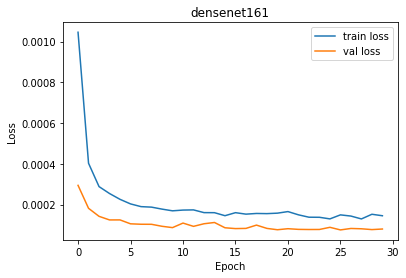

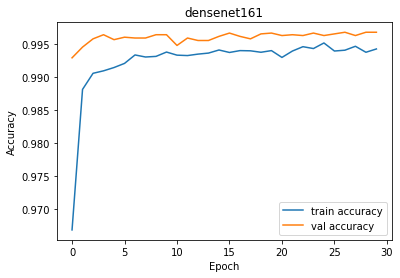

In [ ]:
# Plot and save logs of train and val loss-accuracy
if model_checkpoint_path_dict.get('densenet161', None) and RESUME_TRAIN:
  # plot train and val loss
  fig_path = Path(logs_destination) / \
      f"densenet161-epochs-{epochs_densenet161_all}-loss-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_loss(train_loss=train_loss_densenet161_all, 
            val_loss=val_loss_densenet161_all, 
            train_label='train loss', 
            val_label='val loss',
            title="densenet161",
            xlabel="Epoch",
            ylabel="Loss",
            save=True,
            save_path=fig_path)

  # plot train and val accuracy
  fig_path = Path(logs_destination) / \
      f"densenet161-epochs-{epochs_densenet161_all}-accuracy-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_accuracy(train_acuracy=train_accuracy_densenet161_all, 
                val_acuracy=val_accuracy_densenet161_all, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="densenet161",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=True,
                save_path=fig_path)

In [ ]:
# Save Latest Training Checkpoint Again 
if model_checkpoint_path_dict.get('densenet161', None) and RESUME_TRAIN:
  # save model checkpoint again
  checkpoint_file_name_densenet161= \
                  f"densenet161-epochs-{epochs_densenet161_all}-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}"
  train_history_densenet161_all = \
                  prepare_history_dict(loss=train_loss_densenet161_all, 
                                      accuracy=train_accuracy_densenet161_all)
  validation_history_densenet161_all = \
                  prepare_history_dict(loss=val_loss_densenet161_all, 
                                      accuracy=val_accuracy_densenet161_all)
  
  model_path_densenet161 = save_model_checkpoint(
                        model_name='densenet161', 
                        model=model_densenet161, 
                        criterion=criterion_densenet161, 
                        optimizer=optimizer_densenet161, 
                        epochs=epochs_densenet161_all, 
                        batch_size=batch_size,
                        train_history=train_history_densenet161_all,
                        validation_history=validation_history_densenet161_all,
                        file_name=checkpoint_file_name_densenet161,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_densenet161:
    saved_model_list['densenet161'] = model_path_densenet161
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'models/densenet161-epochs-30-10_24_2021_02_45_48.pth'


### AlexNet

In [ ]:
# Load Saved Model Checkpoint
if model_checkpoint_path_dict.get('alexnet', None) is not None:
  # pretrained alexnet model
  model_alexnet = models.alexnet(pretrained=True)

  # Freeze weights
  for param in model_alexnet.parameters():
    param.requires_grad = False
  
  # see the number of features
  n_features_alexnet = model_alexnet.classifier[1].in_features
  print(n_features_alexnet)

  # We're doing binary classification
  model_alexnet.classifier = nn.Linear(n_features_alexnet, 2)

  # Use GPU if available
  print(device)
  model_alexnet.to(device)

  # Loss and optimizer
  criterion_alexnet = nn.CrossEntropyLoss()
  optimizer_alexnet = torch.optim.Adam(model_alexnet.parameters())

  # load the model checkpoint
  checkpoint_alexnet = load_model_checkpoint(
                      model_checkpoint_path_dict.get('alexnet'))

  # load model weights state_dict
  model_alexnet.load_state_dict(checkpoint_alexnet['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer_alexnet.load_state_dict(checkpoint_alexnet['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  # Previous epochs
  epochs_alexnet_pre = checkpoint_alexnet['epoch']
  print(f"Previously trained for {epochs_alexnet_pre} number of epochs...")

  # load the criterion
  criterion_alexnet = checkpoint_alexnet['loss']
  print('Trained model loss function loaded...')

  train_loss_alexnet_pre, train_accuracy_alexnet_pre = retrieve_history_list(
                                checkpoint_alexnet['train_history'])
  val_loss_alexnet_pre, val_accuracy_alexnet_pre = retrieve_history_list(
                                checkpoint_alexnet['validation_history'])

9216
cuda:0
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 29 number of epochs...
Trained model loss function loaded...


In [ ]:
# Resume Training
if model_checkpoint_path_dict.get('alexnet', None) and RESUME_TRAIN:
  # train for more epochs
  epochs_alexnet_new = new_epochs
  print(f"Train for {epochs_alexnet_new} more epochs...")

  # resume train
  train_loss_alexnet_new, train_accuracy_alexnet_new, val_loss_alexnet_new, \
  val_accuracy_alexnet_new = train_and_validate(
        model=model_alexnet, 
        criterion=criterion_alexnet, 
        optimizer=optimizer_alexnet, 
        train_loader=train_loader, 
        test_loader=test_loader, 
        device=device, 
        epochs=epochs_alexnet_new)
  
  # togather all things
  train_loss_alexnet_all = train_loss_alexnet_pre + train_loss_alexnet_new
  train_accuracy_alexnet_all = train_accuracy_alexnet_pre \
                              + train_accuracy_alexnet_new
  val_loss_alexnet_all = val_loss_alexnet_pre + val_loss_alexnet_new
  val_accuracy_alexnet_all = val_accuracy_alexnet_pre + val_accuracy_alexnet_new
  epochs_alexnet_all = epochs_alexnet_pre + epochs_alexnet_new

Train for 1 more epochs...
Epoch 1 of 1
Train Loss: 0.000056, Train Acc: 0.998406
Val Loss: 0.000068, Val Acc: 0.998625
Duration: 0:02:53.093954


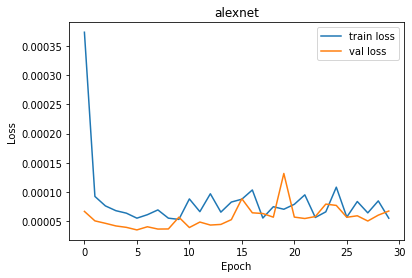

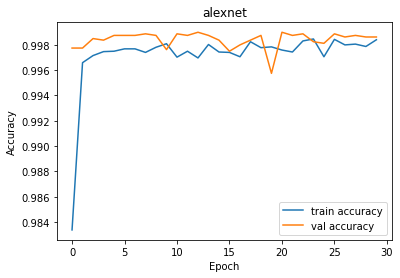

In [ ]:
# Plot and save logs of train and val loss-accuracy
if model_checkpoint_path_dict.get('alexnet', None) and RESUME_TRAIN:
  # plot train and val loss
  fig_path = Path(logs_destination) / \
      f"alexnet-epochs-{epochs_alexnet_all}-loss-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_loss(train_loss=train_loss_alexnet_all, 
            val_loss=val_loss_alexnet_all, 
            train_label='train loss', 
            val_label='val loss',
            title="alexnet",
            xlabel="Epoch",
            ylabel="Loss",
            save=True,
            save_path=fig_path)

  # plot train and val accuracy
  fig_path = Path(logs_destination) / \
      f"alexnet-epochs-{epochs_alexnet_all}-accuracy-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
  plot_accuracy(train_acuracy=train_accuracy_alexnet_all, 
                val_acuracy=val_accuracy_alexnet_all, 
                train_label='train accuracy', 
                val_label='val accuracy',
                title="alexnet",
                xlabel="Epoch",
                ylabel="Accuracy",
                save=True,
                save_path=fig_path)

In [ ]:
# Save Latest Training Checkpoint Again 
if model_checkpoint_path_dict.get('alexnet', None) and RESUME_TRAIN:
  # save model checkpoint again
  checkpoint_file_name_alexnet= \
                  f"alexnet-epochs-{epochs_alexnet_all}-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}"
  train_history_alexnet_all = \
                  prepare_history_dict(loss=train_loss_alexnet_all, 
                                      accuracy=train_accuracy_alexnet_all)
  validation_history_alexnet_all = \
                  prepare_history_dict(loss=val_loss_alexnet_all, 
                                      accuracy=val_accuracy_alexnet_all)
  
  model_path_alexnet = save_model_checkpoint(
                        model_name='alexnet', 
                        model=model_alexnet, 
                        criterion=criterion_alexnet, 
                        optimizer=optimizer_alexnet, 
                        epochs=epochs_alexnet_all, 
                        batch_size=batch_size,
                        train_history=train_history_alexnet_all,
                        validation_history=validation_history_alexnet_all,
                        file_name=checkpoint_file_name_alexnet,
                        destination=saved_model_destination, 
                        overwrite=False)
  if model_path_alexnet:
    saved_model_list['alexnet'] = model_path_alexnet
  else:
    raise Exception("Error: Model did not saved succesfully!")

Model checkpoint saved at 'models/alexnet-epochs-30-10_24_2021_02_48_49.pth'


## Save Logs

In [ ]:
if SAVE_LOGS_TO_GOOGLE_DRIVE and GOOGLE_DRIVE_LOGS_PATH:
  # see inside gdrive
  print(*os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME), sep='\n')
  # select location of gdrive
  gdrive_logs_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_LOGS_PATH}'
  print(*os.listdir(gdrive_logs_path), sep='\n')

  # copy colab models to gdrive
  # how to : https://stackoverflow.com/q/59710439/8520849
  # !cp -av 'logs' 'gdrive/MyDrive/ML/concrete_crack_detection/logs'
  # os.system("cp -av {} {}".format(logs_destination, gdrive_logs_path))
  copytree(src=logs_destination, dst=gdrive_logs_path)

.shortcut-targets-by-id
.file-revisions-by-id
MyDrive
.Trash-0
vgg16-epochs-7-loss-10_23_2021_11_09_23.png
vgg16-epochs-7-accuracy-10_23_2021_11_09_24.png
resnet18-epochs-7-accuracy-10_23_2021_11_16_24.png
resnet18-epochs-7-loss-10_23_2021_11_16_24.png
densenet161-epochs-7-loss-10_23_2021_11_42_41.png
densenet161-epochs-7-accuracy-10_23_2021_11_42_42.png
alexnet-epochs-7-accuracy-10_23_2021_11_48_27.png
alexnet-epochs-7-loss-10_23_2021_11_48_27.png
vgg16--confusion_matrix-10_23_2021_10_27_59.png
vgg16--precision_recall_display-10_23_2021_10_27_59.png
vgg16-epochs-3-loss-10_23_2021_08_28_17.png
alexnet--classification_report-10_23_2021_10_31_20.json
alexnet--precision_recall_display-10_23_2021_10_31_20.png
resnet18-epochs-3-accuracy-10_23_2021_08_35_27.png
alexnet--confusion_matrix-10_23_2021_09_12_09.png
densenet161--classification_report-10_23_2021_09_11_44.json
densenet161--precision_recall_display-10_23_2021_09_11_44.png
vgg16--classification_report-10_23_2021_10_27_58.json
alexnet-

## Save Checkpoint to Google Drive

In [ ]:
if SAVE_MODELS_TO_GOOGLE_DRIVE and (RESUME_TRAINING_STAGE or\
                                   ACTIVE_INITIAL_TRAINING_STAGE):
  # see inside gdrive
  print(*os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME), sep='\n')
  # select location of gdrive
  gdrive_models_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_MODELS_PATH}'
  print(*os.listdir(gdrive_models_path), sep='\n')

  # copy colab models to gdrive
  # how to : https://stackoverflow.com/q/59710439/8520849
  # !cp -av 'models' 'gdrive/MyDrive/ML/concrete_crack_detection/models'
  # os.system("cp -av {} {}".format(saved_model_destination, gdrive_models_path))
  copytree(src=saved_model_destination, dst=gdrive_models_path)

.shortcut-targets-by-id
.file-revisions-by-id
MyDrive
.Trash-0
resnet18-epochs-1-2021-10-23 05:30:52.401421.pth
vgg16-epochs-1-2021-10-23 05:30:52.132006.pth
densenet161-epochs-1-2021-10-23 05:30:52.647853.pth
alexnet-epochs-1-2021-10-23 05:30:53.656397.pth
vgg16-epochs-7-10_23_2021_11_09_24.pth
resnet18-epochs-7-10_23_2021_11_16_24.pth
densenet161-epochs-7-10_23_2021_11_42_42.pth
alexnet-epochs-7-10_23_2021_11_48_27.pth
alexnet-epochs-5-10_23_2021_10_26_28.pth
resnet18-epochs-5-10_23_2021_09_54_36.pth
alexnet-epochs-3-10_23_2021_09_07_21.pth
vgg16-epochs-3-10_23_2021_08_28_17.pth
densenet161-epochs-5-10_23_2021_10_20_42.pth
resnet18-epochs-3-10_23_2021_08_35_27.pth
vgg16-epochs-5-10_23_2021_09_47_32.pth
densenet161-epochs-3-10_23_2021_09_01_35.pth
vgg16-epochs-9-10_23_2021_13_22_24.pth
resnet18-epochs-9-10_23_2021_13_29_29.pth
densenet161-epochs-9-10_23_2021_13_56_53.pth
alexnet-epochs-9-10_23_2021_14_02_29.pth
vgg16-epochs-21-10_23_2021_19_33_36.pth
resnet18-epochs-21-10_23_2021_19_4

# Conclusions

## Evaluation Method

In [ ]:
#@title **Evaluation Method**

#@markdown  *Confusion Matrix*, *Precision*, *Recall*, *F1 Scrore*, and Validation *Accuracy* are the standard evaluation method for the classification model.

#@markdown **Confusion Matrix** as the name suggests gives us a matrix as output and describes the complete performance of the model.

#@markdown | Actual / Predicted| Positive               | Negetive               |
#@markdown | :---------------- |   :-----------------:  |  :-----------------:   |
#@markdown |  Positive         | True Positive (**TP**) | False Negetive (**FN**)|
#@markdown |  Negetive         | False Positive (**FP**)| True Negetive (**TN**) |

#@markdown **Precision** is the number of correctly identified cases among all the identified cases. 
#@markdown $$Precision, P = \frac{TP}{TP + FP}$$

#@markdown **Recall** is the number of correctly identified cases from all the positive representations. 
#@markdown $$Recall, R = \frac{TP}{TP + FN}$$

#@markdown **F1 score** is the harmonic average of precision and recall.
#@markdown $$F1Scrore, F1 = 2\times \frac{P \times R}{P + R}$$

#@markdown **Accuracy** is the ratio of number of correct predictions to the total number of input sampols.
#@markdown $$Accuracy = \frac{Number of Correct predictions}{Total number of predictions made}$$

In [ ]:
# evaluation function
def evaluate(model, criterion, optimizer, dataloader, device):
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0

  pred_list = np.empty(shape=0)
  target_list = np.empty(shape=0)

  with torch.no_grad():
    for inputs, targets in dataloader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Get prediction
      # torch.max returns both max and argmax
      _, predictions = torch.max(outputs, 1)

      val_running_loss += loss.item()
      val_running_correct += (predictions == targets).sum().item()

      # store predictions and targets for showing Evaluation Statistics
      pred_list = np.concatenate((pred_list, predictions.cpu().detach().numpy()), axis=0)
      target_list = np.concatenate((target_list, targets.cpu().detach().numpy()), axis=0)
    
    val_loss = val_running_loss/len(dataloader.dataset)
    val_accuracy = val_running_correct/len(dataloader.dataset)
    history = {
        'loss': val_loss,
        'accuracy': val_accuracy,
        'y_true': target_list,
        'y_pred': pred_list
    }
    return history

In [ ]:
def show_evaluation_history(y_true, y_pred, pos_label, y_labels, y_label_names, 
                            save=False, save_path_dir=None, file_name_prefix=None):
  # show classification report
  print("Classification Report:")
  cls_rep_str = classification_report(y_true=y_true, 
                                  y_pred=y_pred, 
                                  labels=y_labels, 
                                  target_names=y_label_names, 
                                  digits=4, 
                                  output_dict=False)
  print(cls_rep_str)
  cls_rep_dict = classification_report(y_true=y_true, 
                                  y_pred=y_pred, 
                                  labels=y_labels, 
                                  target_names=y_label_names, 
                                  digits=4, 
                                  output_dict=True)
  print(cls_rep_dict)
  # save classification_report as json file
  if save and save_path_dir:
    try:
      import json
      file_path = Path(save_path_dir) / \
              f"{file_name_prefix if file_name_prefix else \
              ''}-classification_report-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.json"
      with open(file_path, "w") as outfile:
        json.dump(cls_rep_dict, outfile)
    except Exception as e:
      print("Classification_report json file save failed!")
      raise e

  # show Precision Recall
  ps = precision_score(y_true=y_true, 
                       y_pred=y_pred, 
                       labels=y_labels, 
                       pos_label=pos_label, 
                       average='binary')
  print(f"precision score: {ps}")

  # show recall score
  rs = recall_score(y_true=y_true, 
                    y_pred=y_pred, 
                    labels=y_labels, 
                    pos_label=pos_label, 
                    average='binary')
  print(f"recall score: {rs}")

  # show f1 score
  f1s = f1_score(y_true=y_true, 
                  y_pred=y_pred, 
                  labels=y_labels, 
                  pos_label=pos_label, 
                  average='binary')
  print(f"F1 score: {f1s}")

  # show accuracy score
  acc_score = accuracy_score(y_true=y_true, 
                             y_pred=y_pred,
                             normalize=True)
  print(f"accuracy score: {acc_score}")

  # show confusion matrix
  print("Confusion matrix:")
  cm = confusion_matrix(y_true=y_true, 
                        y_pred=y_pred, 
                        labels=y_labels, 
                        normalize=None)
  cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_labels)
  cm_disp.plot()

  if save and save_path_dir:
    try:
      file_path = Path(save_path_dir) / \
              f"{file_name_prefix if file_name_prefix else \
              ''}-confusion_matrix-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
      plt.savefig(file_path)
    except Exception as e:
      print("Figure save failed!")
      raise e
  plt.show()

  # show Precision Recall Display
  precision, recall, _ = precision_recall_curve(y_true=y_true, 
                                                probas_pred=y_pred,
                                                pos_label=pos_label)
  print(f"precision_recall_curve: precision={precision} and recall={recall}")
  average_precision = average_precision_score(y_true=y_true, 
                                              y_score=y_pred,
                                              average='macro',
                                              pos_label=pos_label)
  prd_disp = PrecisionRecallDisplay(precision=precision, 
                                    recall=recall,
                                    average_precision=average_precision, 
                                    estimator_name=None)
  prd_disp.plot()
  if save and save_path_dir:
    try:
      file_path = Path(save_path_dir) / \
              f"{file_name_prefix if file_name_prefix else \
              ''}-precision_recall_display-{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.png"
      plt.savefig(file_path)
    except Exception as e:
      print("Figure save failed!")
      raise e
  plt.show()

### Important Considerations

- Our data set labels as `crack` and `noncrack`
- After loading dataset into dataloader we have seen labes are converted as numbers, also `crack` as `0` and `noncrack` as `1`. We confermed that by seeing number of crack and noncrack images into test dataset and later comparing with `targets` which was represented as *Tensor* with values `0` and `1` representing class labels.
- So in our case **positive label** `crack` represnting as `pos_label=0` for **binary classification**.




In [ ]:
# according to our binary classification problem and seeing dataloader targets reprentation
# positive class `crack` represnting as `pos_label=0`
# Store it a variable for later use. Otherwise, some function in binary classification `pos_label: default=1`
POS_LABEL = 0
# store corresponding string name
POS_LABEL_NAME = 'crack'

# Store all Class Label name in a variable for later use
# keep in mind store them as 0 indexed sequnce, so order is very important
Y_LABELS = [0, 1] # corresponding list of label indices
Y_LABEL_NAMES = ['crack', 'noncrack'] # 0 index for `crack` and 1 index for `noncrack`


### VGG

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('vgg16', None):
  # evaluate model
  vgg16_history = evaluate(
        model=model_vgg16, 
        criterion=criterion_vgg16, 
        optimizer=optimizer_vgg16,
        dataloader=test_loader, 
        device=device)

Classification Report:
              precision    recall  f1-score   support

       crack     0.9973    0.9990    0.9981      4000
    noncrack     0.9990    0.9973    0.9981      4001

    accuracy                         0.9981      8001
   macro avg     0.9981    0.9981    0.9981      8001
weighted avg     0.9981    0.9981    0.9981      8001

{'crack': {'precision': 0.9972548040928375, 'recall': 0.999, 'f1-score': 0.9981266391907081, 'support': 4000}, 'noncrack': {'precision': 0.99899849774662, 'recall': 0.9972506873281679, 'f1-score': 0.99812382739212, 'support': 4001}, 'accuracy': 0.9981252343457068, 'macro avg': {'precision': 0.9981266509197287, 'recall': 0.998125343664084, 'f1-score': 0.9981252332914141, 'support': 8001}, 'weighted avg': {'precision': 0.9981267598869613, 'recall': 0.9981252343457068, 'f1-score': 0.9981252331156987, 'support': 8001}}
precision score: 0.9972548040928375
recall score: 0.999
F1 score: 0.9981266391907081
accuracy score: 0.9981252343457068
Confusion

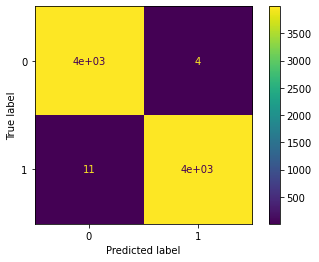

precision_recall_curve: precision=[0.49993751 0.0010015  1.        ] and recall=[1.    0.001 0.   ]


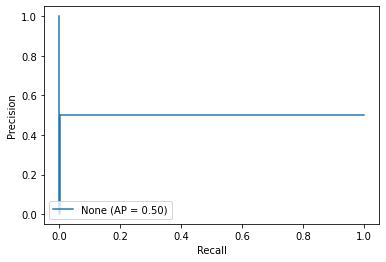

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('vgg16', None):  
  show_evaluation_history(y_true=vgg16_history['y_true'], 
                          y_pred=vgg16_history['y_pred'], 
                          pos_label=POS_LABEL,
                          y_labels=Y_LABELS, 
                          y_label_names=Y_LABEL_NAMES, 
                          save=True, 
                          save_path_dir=LOGS_DIRNAME, 
                          file_name_prefix='vgg16-')


### ResNet

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('resnet18', None):
  # evaluate model
  resnet18_history = evaluate(
        model=model_resnet18, 
        criterion=criterion_resnet18, 
        optimizer=optimizer_resnet18,
        dataloader=test_loader, 
        device=device)

Classification Report:
              precision    recall  f1-score   support

       crack     0.9896    0.9970    0.9933      4000
    noncrack     0.9970    0.9895    0.9932      4001

    accuracy                         0.9933      8001
   macro avg     0.9933    0.9933    0.9933      8001
weighted avg     0.9933    0.9933    0.9933      8001

{'crack': {'precision': 0.9895781637717121, 'recall': 0.997, 'f1-score': 0.9932752179327521, 'support': 4000}, 'noncrack': {'precision': 0.9969780911609166, 'recall': 0.989502624343914, 'f1-score': 0.9932262920220772, 'support': 4001}, 'accuracy': 0.9932508436445444, 'macro avg': {'precision': 0.9932781274663144, 'recall': 0.9932513121719571, 'f1-score': 0.9932507549774147, 'support': 8001}, 'weighted avg': {'precision': 0.9932785899039716, 'recall': 0.9932508436445444, 'f1-score': 0.9932507519199274, 'support': 8001}}
precision score: 0.9895781637717121
recall score: 0.997
F1 score: 0.9932752179327521
accuracy score: 0.9932508436445444
Confu

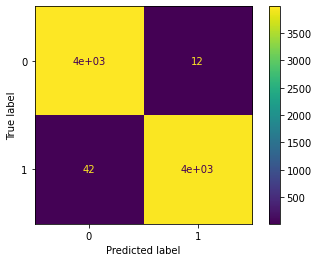

precision_recall_curve: precision=[0.49993751 0.00302191 1.        ] and recall=[1.    0.003 0.   ]


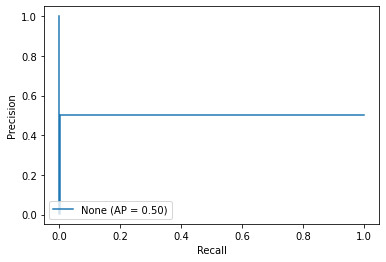

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('resnet18', None):  
  show_evaluation_history(y_true=resnet18_history['y_true'], 
                          y_pred=resnet18_history['y_pred'], 
                          pos_label=POS_LABEL,
                          y_labels=Y_LABELS, 
                          y_label_names=Y_LABEL_NAMES, 
                          save=True, 
                          save_path_dir=LOGS_DIRNAME, 
                          file_name_prefix='resnet18-')


### DenseNet

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('densenet161', None):
  # evaluate model
  densenet161_history = evaluate(
        model=model_densenet161, 
        criterion=criterion_densenet161, 
        optimizer=optimizer_densenet161,
        dataloader=test_loader, 
        device=device)

Classification Report:
              precision    recall  f1-score   support

       crack     0.9950    0.9985    0.9968      4000
    noncrack     0.9985    0.9950    0.9967      4001

    accuracy                         0.9968      8001
   macro avg     0.9968    0.9968    0.9968      8001
weighted avg     0.9968    0.9968    0.9968      8001

{'crack': {'precision': 0.9950174389636273, 'recall': 0.9985, 'f1-score': 0.9967556775642624, 'support': 4000}, 'noncrack': {'precision': 0.9984951091045899, 'recall': 0.9950012496875781, 'f1-score': 0.9967451176765149, 'support': 4001}, 'accuracy': 0.9967504061992251, 'macro avg': {'precision': 0.9967562740341086, 'recall': 0.9967506248437891, 'f1-score': 0.9967503976203886, 'support': 8001}, 'weighted avg': {'precision': 0.9967564913613265, 'recall': 0.9967504061992251, 'f1-score': 0.9967503969604781, 'support': 8001}}
precision score: 0.9950174389636273
recall score: 0.9985
F1 score: 0.9967556775642624
accuracy score: 0.9967504061992251
Co

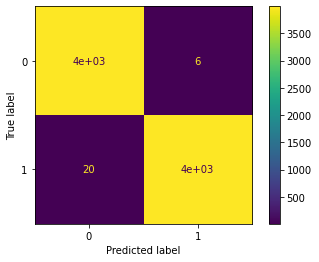

precision_recall_curve: precision=[0.49993751 0.00150489 1.        ] and recall=[1.     0.0015 0.    ]


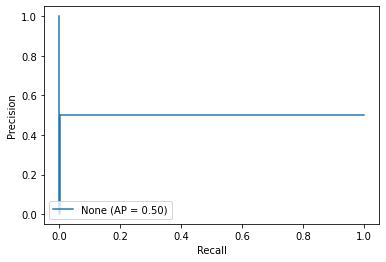

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('densenet161', None):  
  show_evaluation_history(y_true=densenet161_history['y_true'], 
                          y_pred=densenet161_history['y_pred'], 
                          pos_label=POS_LABEL,
                          y_labels=Y_LABELS, 
                          y_label_names=Y_LABEL_NAMES, 
                          save=True, 
                          save_path_dir=LOGS_DIRNAME, 
                          file_name_prefix='densenet161-')


### AlexNet

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('alexnet', None):
  # evaluate model
  alexnet_history = evaluate(
        model=model_alexnet, 
        criterion=criterion_alexnet, 
        optimizer=optimizer_alexnet,
        dataloader=test_loader, 
        device=device)

Classification Report:
              precision    recall  f1-score   support

       crack     0.9992    0.9980    0.9986      4000
    noncrack     0.9980    0.9993    0.9986      4001

    accuracy                         0.9986      8001
   macro avg     0.9986    0.9986    0.9986      8001
weighted avg     0.9986    0.9986    0.9986      8001

{'crack': {'precision': 0.9992490613266584, 'recall': 0.998, 'f1-score': 0.9986241400875547, 'support': 4000}, 'noncrack': {'precision': 0.9980029955067399, 'recall': 0.9992501874531368, 'f1-score': 0.998626202073186, 'support': 4001}, 'accuracy': 0.9986251718535183, 'macro avg': {'precision': 0.9986260284166991, 'recall': 0.9986250937265684, 'f1-score': 0.9986251710803704, 'support': 8001}, 'weighted avg': {'precision': 0.9986259505473191, 'recall': 0.9986251718535183, 'f1-score': 0.9986251712092283, 'support': 8001}}
precision score: 0.9992490613266584
recall score: 0.998
F1 score: 0.9986241400875547
accuracy score: 0.9986251718535183
Confu

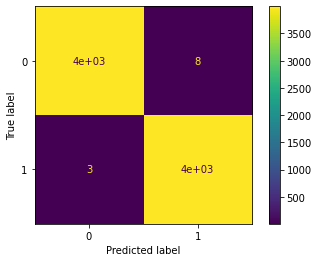

precision_recall_curve: precision=[0.49993751 0.001997   1.        ] and recall=[1.    0.002 0.   ]


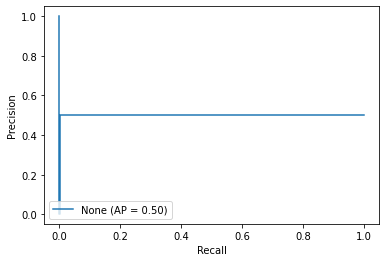

In [ ]:
if ACTIVE_EVALUATION_STAGE and model_checkpoint_path_dict.get('alexnet', None):  
  show_evaluation_history(y_true=alexnet_history['y_true'], 
                          y_pred=alexnet_history['y_pred'], 
                          pos_label=POS_LABEL,
                          y_labels=Y_LABELS, 
                          y_label_names=Y_LABEL_NAMES, 
                          save=True, 
                          save_path_dir=LOGS_DIRNAME, 
                          file_name_prefix='alexnet-')


## Save Logs

In [ ]:
if SAVE_LOGS_TO_GOOGLE_DRIVE and GOOGLE_DRIVE_LOGS_PATH:
  # see inside gdrive
  print(*os.listdir(GOOGLE_DRIVE_MOUNTED_DIRNAME), sep='\n')
  # select location of gdrive
  gdrive_logs_path = f'{GOOGLE_DRIVE_MOUNTED_DIRNAME}/{GOOGLE_DRIVE_LOGS_PATH}'
  print(*os.listdir(gdrive_logs_path), sep='\n')

  # copy colab models to gdrive
  # how to : https://stackoverflow.com/q/59710439/8520849
  # !cp -av 'logs' 'gdrive/MyDrive/ML/concrete_crack_detection/logs'
  # os.system("cp -av {} {}".format(logs_destination, gdrive_logs_path))
  copytree(src=logs_destination, dst=gdrive_logs_path)

.shortcut-targets-by-id
.file-revisions-by-id
MyDrive
.Trash-0
vgg16-epochs-7-loss-10_23_2021_11_09_23.png
vgg16-epochs-7-accuracy-10_23_2021_11_09_24.png
resnet18-epochs-7-accuracy-10_23_2021_11_16_24.png
resnet18-epochs-7-loss-10_23_2021_11_16_24.png
densenet161-epochs-7-loss-10_23_2021_11_42_41.png
densenet161-epochs-7-accuracy-10_23_2021_11_42_42.png
alexnet-epochs-7-accuracy-10_23_2021_11_48_27.png
alexnet-epochs-7-loss-10_23_2021_11_48_27.png
vgg16--confusion_matrix-10_23_2021_10_27_59.png
vgg16--precision_recall_display-10_23_2021_10_27_59.png
vgg16-epochs-3-loss-10_23_2021_08_28_17.png
alexnet--classification_report-10_23_2021_10_31_20.json
alexnet--precision_recall_display-10_23_2021_10_31_20.png
resnet18-epochs-3-accuracy-10_23_2021_08_35_27.png
alexnet--confusion_matrix-10_23_2021_09_12_09.png
densenet161--classification_report-10_23_2021_09_11_44.json
densenet161--precision_recall_display-10_23_2021_09_11_44.png
vgg16--classification_report-10_23_2021_10_27_58.json
alexnet-

## Models used for Transfer Learning

We applied transfer learning technique based on the following models:
*   [VGG](https://arxiv.org/abs/1409.1556)
*   [ResNet](https://arxiv.org/abs/1512.03385)
*   [DenseNet](https://arxiv.org/abs/1608.06993)
*   [AlexNet](https://arxiv.org/abs/1404.5997)